In [1]:
from mcbj import *
from pca_and_ml import *
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, StrMethodFormatter
import pandas as pd

date = "22_11_03"
sample_rate = 50_000
home_folder = Path(f"D:/BJ_Data/{date}")

In [2]:
trace_num=39101+83

<AxesSubplot:xlabel='Piezo [V]', ylabel='Conductance [$G_{0}$]'>

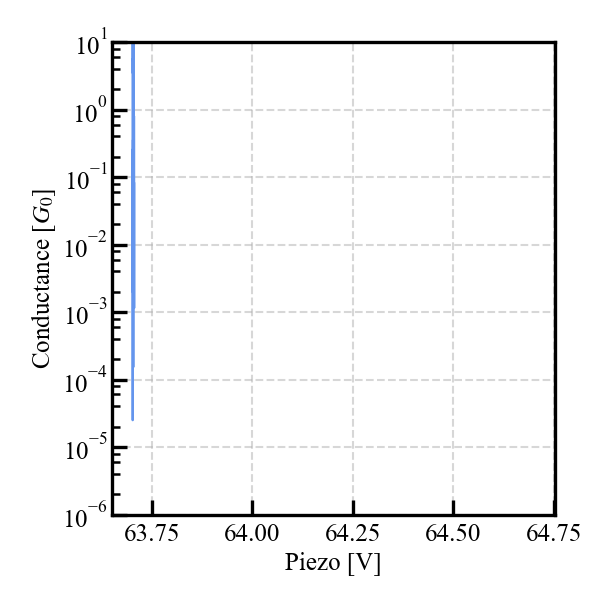

In [3]:
trace_num += 1
trace_pair = TracePair(trace_num, load_from=home_folder)
trace_pair.plot_trace_pair(dpi=300)

In [4]:
# before_evap = np.arange(start=1, stop=3000, step=1)
after_evap_fast = np.arange(start=3001, stop=39100, step=1)
after_evap_slow = np.arange(start=39102, stop=69000, step=1)
# all_traces = np.hstack((before_evap, after_evap_fast, after_evap_slow))

In [5]:
int(np.ceil(after_evap_slow.shape[0]/7500))

4

In [6]:
after_evap_slow_parts = [after_evap_slow[i*7500:(i+1)*7500] for i in range(int(np.ceil(after_evap_slow.shape[0]/7500)))]

In [7]:
print('number of traces in each part:')
print(list(map(len, after_evap_slow_parts)))

number of traces in each part:
[7500, 7500, 7500, 7398]


In [8]:
hist_parts = []
for i in range(int(np.ceil(after_evap_slow.shape[0]/7500))):
    hist = Histogram(folder=home_folder,
                     traces=after_evap_slow_parts[i],
                     conductance_range=(1e-5, 10),
                     conductance_bins_num=100,
                     conductance_bins_mode='total')
    hist_parts.append(hist)

In [9]:
hist_parts[0].calc_stats(align_at=0.5,
                         range_pull=(-1, 1),
                         range_push=(-0.5, 1.5))

  0%|          | 0/7500 [00:00<?, ?it/s]

Pull 2D histogram created from 7095 traces
Push 2D histogram created from 7095 traces


In [14]:
hist_parts[1].calc_stats(align_at=0.5,
                         range_pull=(-1, 1),
                         range_push=(-0.5, 1.5))

  0%|          | 0/7500 [00:00<?, ?it/s]

Pull 2D histogram created from 7074 traces
Push 2D histogram created from 7074 traces


In [15]:
hist_parts[2].calc_stats(align_at=0.5,
                         range_pull=(-1, 1),
                         range_push=(-0.5, 1.5))

  0%|          | 0/7500 [00:00<?, ?it/s]

Pull 2D histogram created from 6994 traces
Push 2D histogram created from 6994 traces


In [16]:
hist_parts[3].calc_stats(align_at=0.5,
                         range_pull=(-1, 1),
                         range_push=(-0.5, 1.5))

  0%|          | 0/7398 [00:00<?, ?it/s]

Pull 2D histogram created from 6911 traces
Push 2D histogram created from 6911 traces


In [20]:
nori_hist_1d = np.loadtxt('D:/Greta/POConductanceHist1D_all_long.txt', skiprows=1)
nori_hist_bins = 10**np.arange(start=-5.82391, step=0.0689284, stop=-5.82391+100*0.0689284)

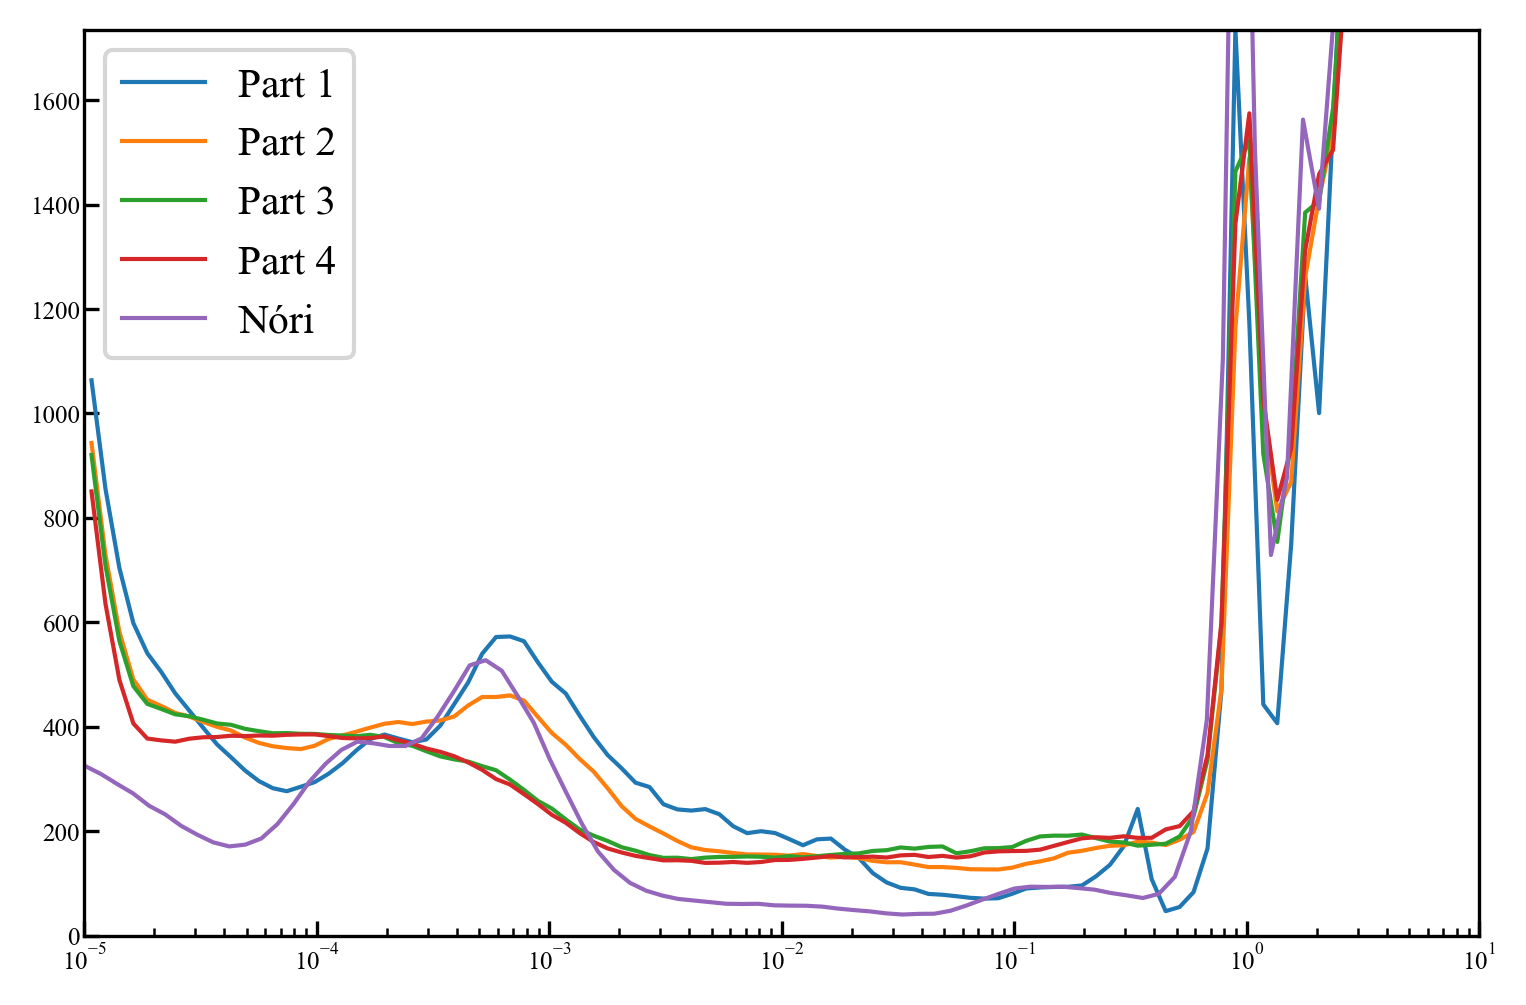

In [24]:
fig, ax = plt.subplots(1, dpi=300)
for i in range(len(hist_parts)):
    ax.plot(hist_parts[i].hist_1d_bins, hist_parts[i].hist_1d_pull, label=f'Part {i+1}', lw=1)

ax.plot(nori_hist_bins, 50*nori_hist_1d, label='Nóri', lw=1)
ax.set_xlim(hist_parts[0].conductance_range)
ax.set_ylim(0, max(list(map(lambda x: max(x.hist_1d_pull[np.bitwise_and(x.hist_1d_bins > 0.7, x.hist_1d_bins < 1.05)]), hist_parts))))
ax.set_xscale('log')
ax.legend()

In [38]:
for hist in hist_parts:
    hist.calc_corr_hist_2d()

  0%|          | 0/7095 [00:00<?, ?it/s]

  0%|          | 0/7074 [00:00<?, ?it/s]

  0%|          | 0/6994 [00:00<?, ?it/s]

  0%|          | 0/6911 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='Conductance $[G_{0}]$', ylabel='Conductance $[G_{0}]$'>,
 <AxesSubplot:>)

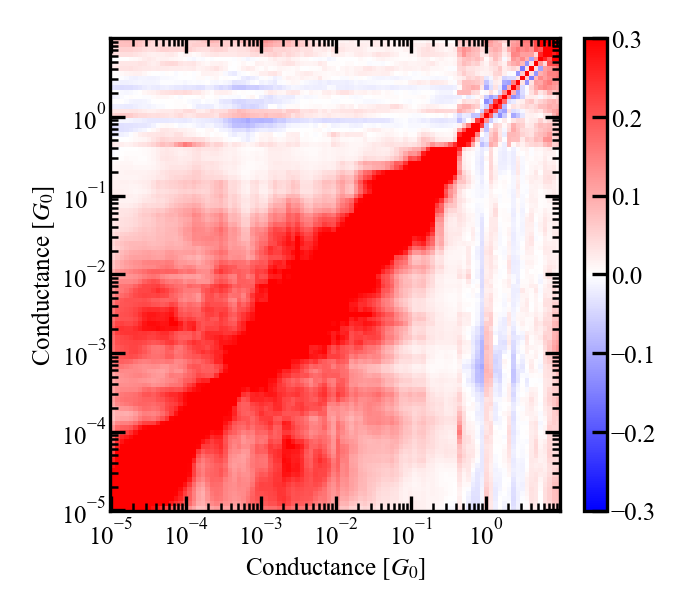

In [52]:
hist_parts[0].plot_corr(mode='pull', dpi=300, vmin=-0.3, vmax=0.3)

In [44]:
pc_part1 = PCA(hist_parts[0], num_of_pcs=5)
pc_part1.calc_principal_components(direction='pull')
pc_part2 = PCA(hist_parts[1], num_of_pcs=5)
pc_part2.calc_principal_components(direction='pull')
pc_part3 = PCA(hist_parts[2], num_of_pcs=5)
pc_part3.calc_principal_components(direction='pull')
pc_part4 = PCA(hist_parts[3], num_of_pcs=5)
pc_part4.calc_principal_components(direction='pull')

In [49]:
def compare_principal_components_more(pcs: Tuple[PCA, ...], labels=None, fig_size=None, dpi=300):
    use_cmap = colormaps['tab20'](np.linspace(0, 1, 20))  # 20 different color, to compare 2 sets of 10 PCs
    number_of_pcs_each = list(map(lambda x: x.num_of_pcs, pcs))
    if np.unique(number_of_pcs_each).shape[0] == 1:
        if labels is None:
            labels = tuple(f'pc{i+1}' for i in range(len(pcs)))
        if fig_size is None:
            fig_size = utils.cm2inch(10, pcs[0].num_of_pcs * 4)
        fig, ax = plt.subplots(nrows=pcs[0].num_of_pcs, figsize=fig_size, dpi=dpi)

        for i, pc_key in enumerate(pcs[0].pc_keys):
            ax[i].set_prop_cycle, cycler('color', use_cmap)
            for j, pc in enumerate(pcs):
                ax[i].plot(pc.hist.hist_1d_bins, pc.principal_components[pc_key], label=labels[j])
            # ax[i].plot(pcs[0].hist.hist_1d_bins, np.zeros_like(pcs[0].hist.hist_1d_bins),
            #            label=f'zero line', lw=0.6, ls='--', c='grey')
            ax[i].axhline(0, ls='--', lw=0.6, c='grey')
            ax[i].set_xscale('log')
            ax[i].set_title(pc_key, fontsize='xx-small', pad=1)
            ax[i].legend(fontsize='xx-small')

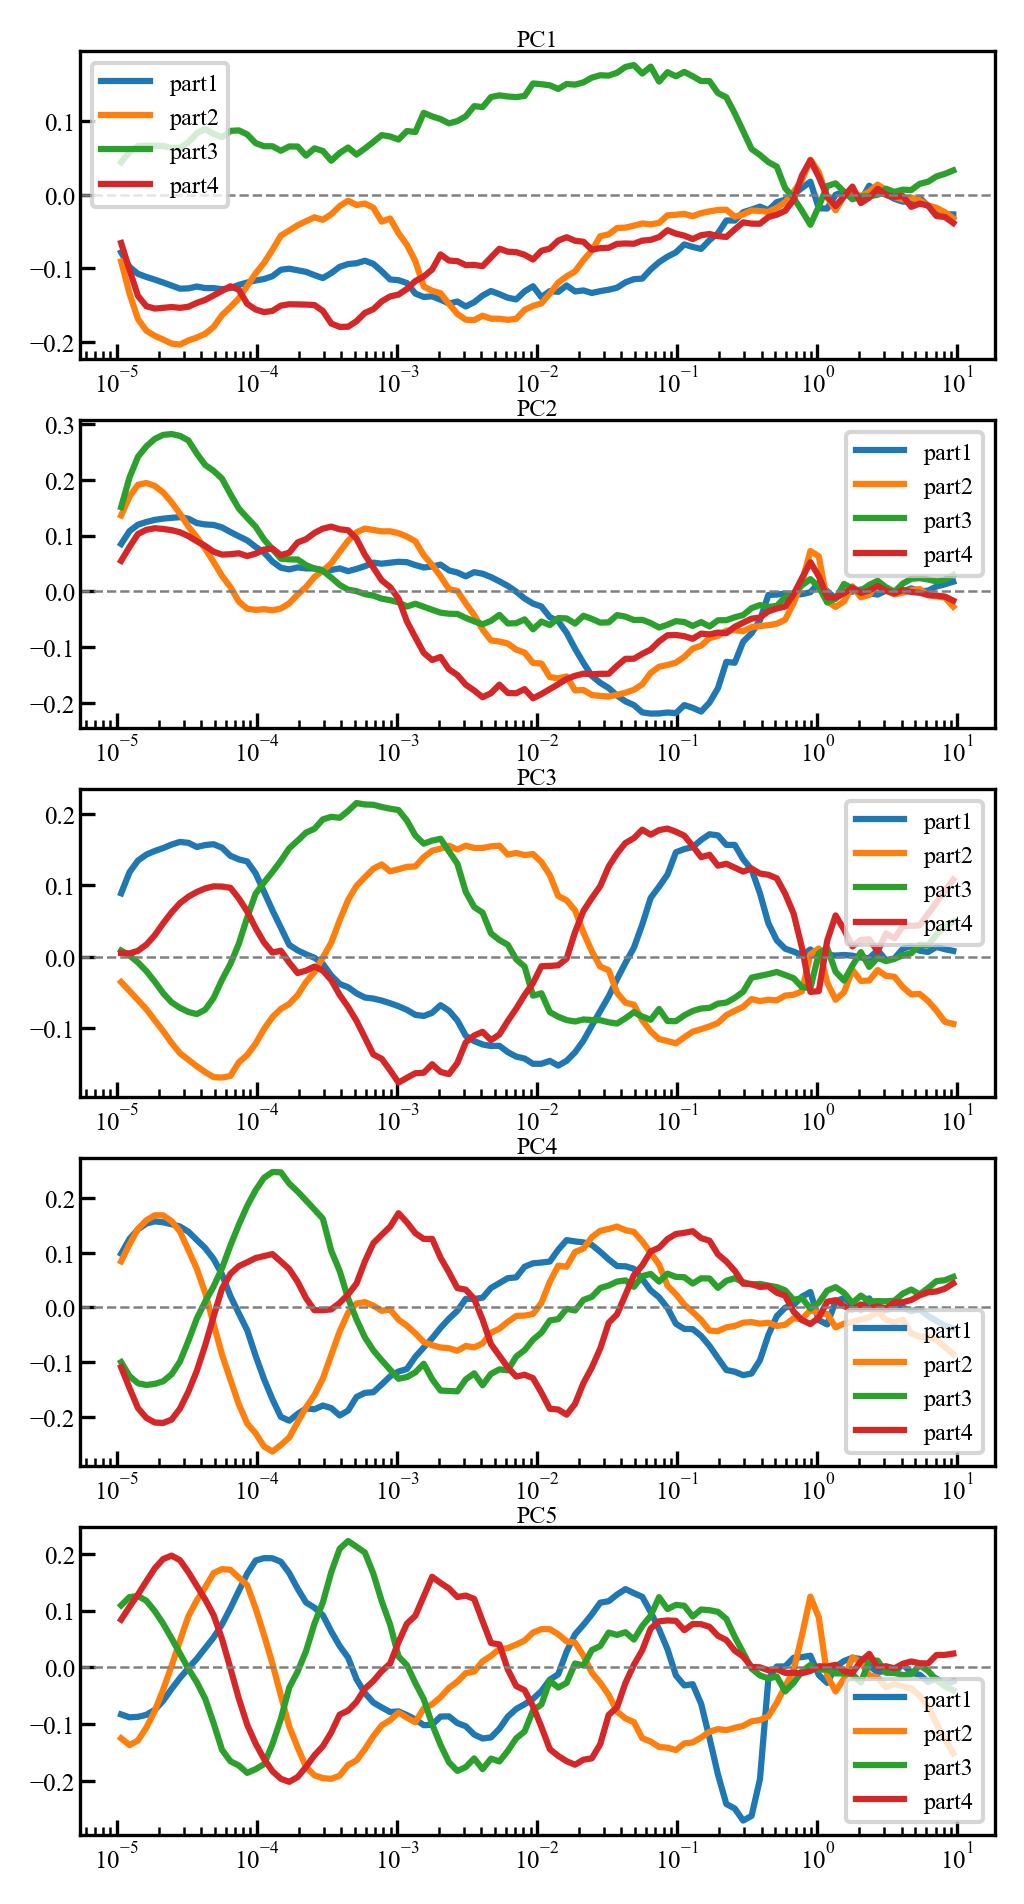

In [50]:
compare_principal_components(pcs=(pc_part1, pc_part2, pc_part3, pc_part4),
                             labels=('part1', 'part2', 'part3', 'part4'), fig_size=None, dpi=300)

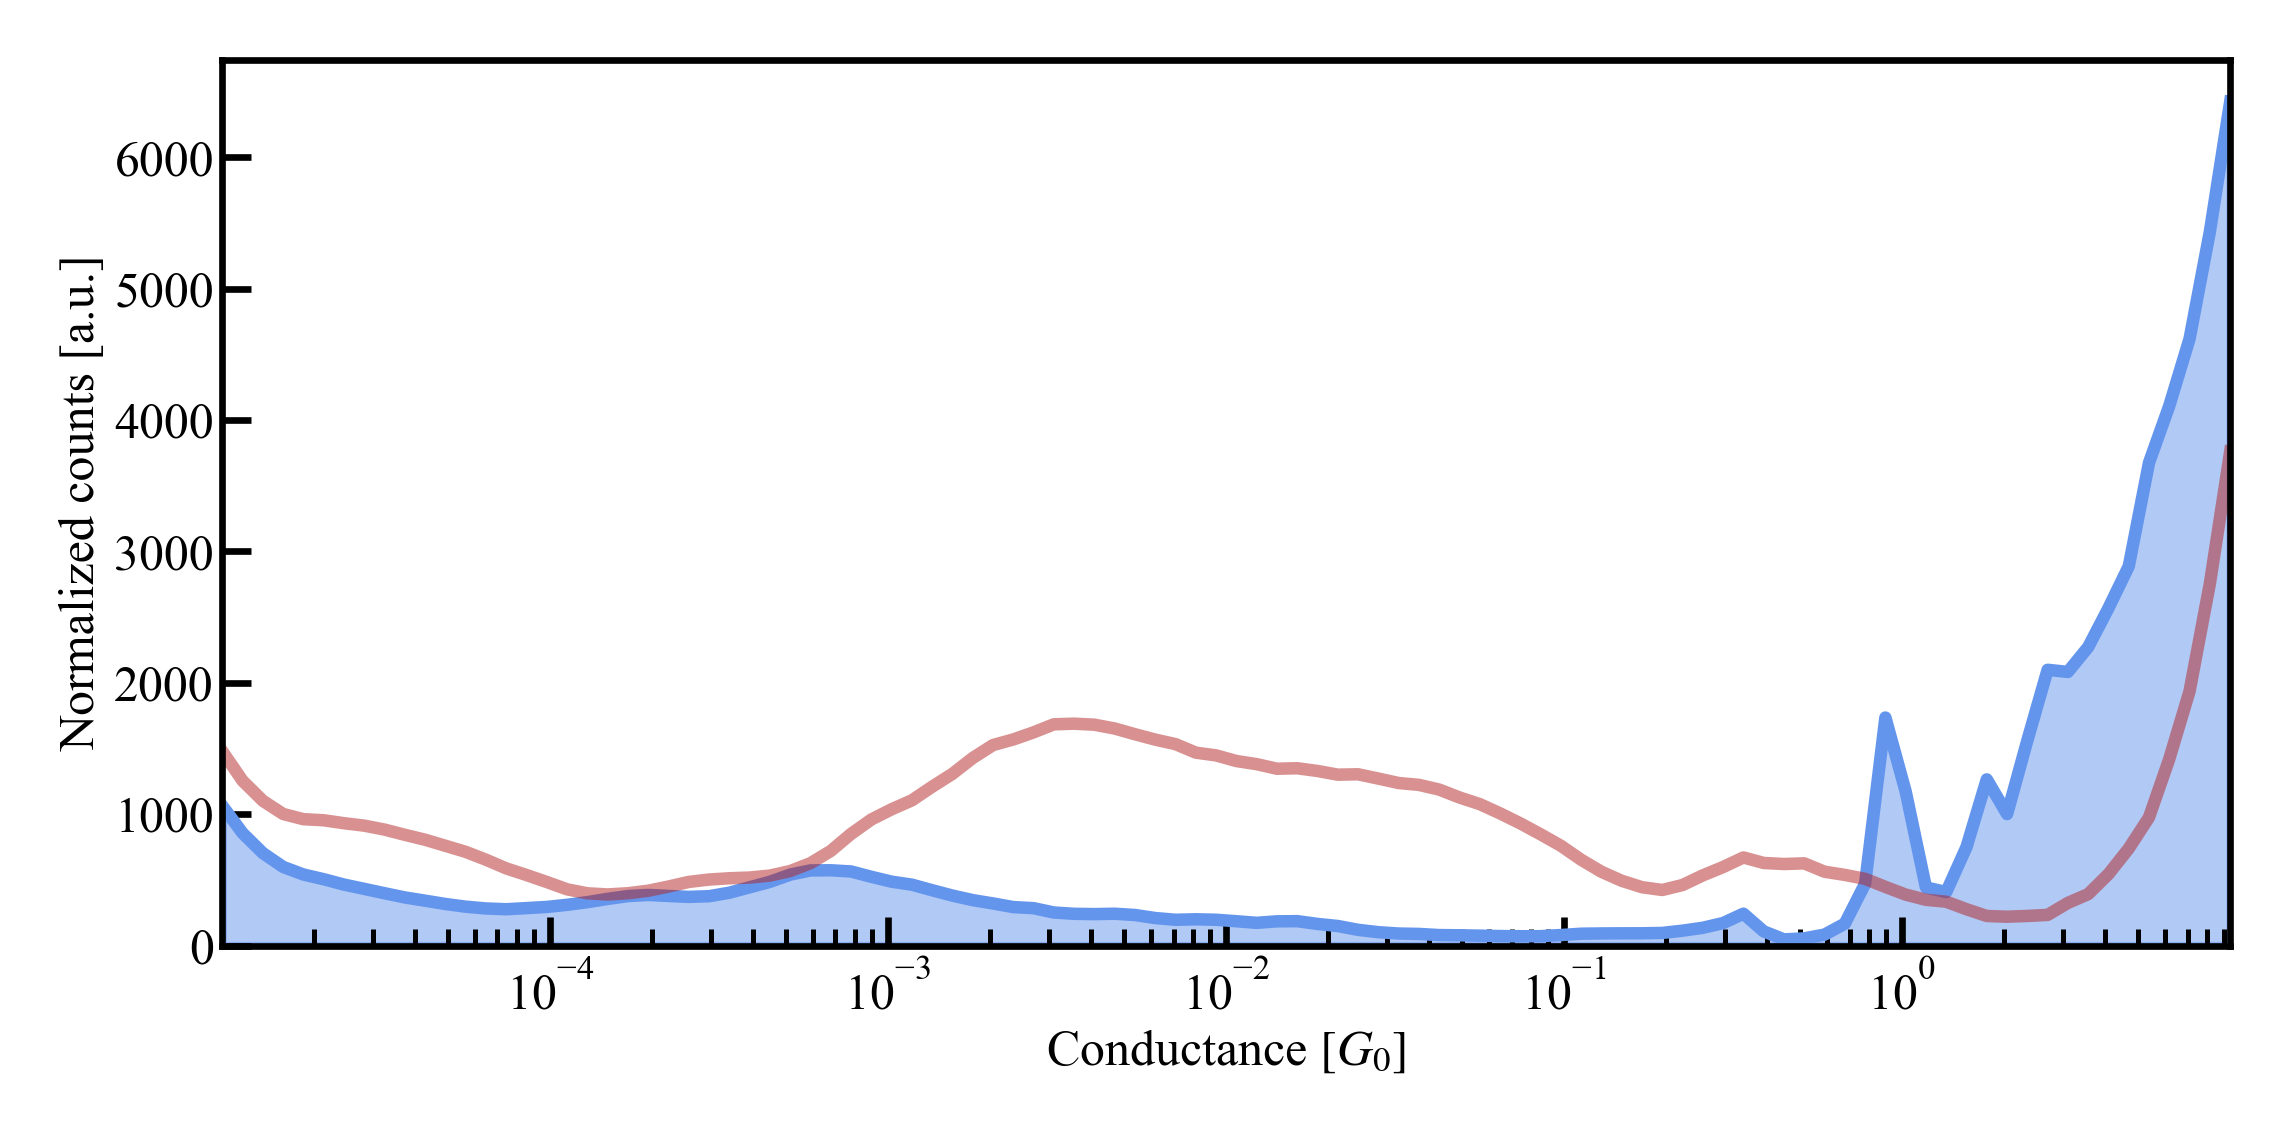

In [11]:
ax = hist_parts[0].plot_hist_1d()
# ax.set_ylim(0, 100)

<AxesSubplot:xlabel='Piezo [V]', ylabel='Conductance [$G_{0}$]'>

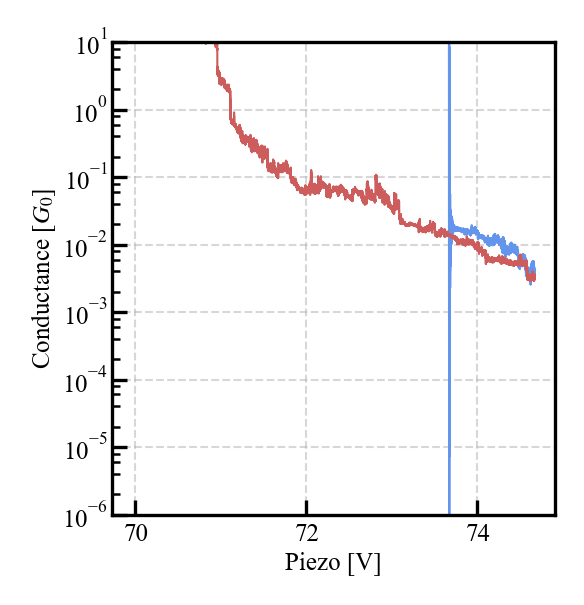

In [35]:
trace_num = hist_parts[0].traces[784]
trace_pair = TracePair(trace_num, load_from=home_folder)
trace_pair.plot_trace_pair(dpi=300)

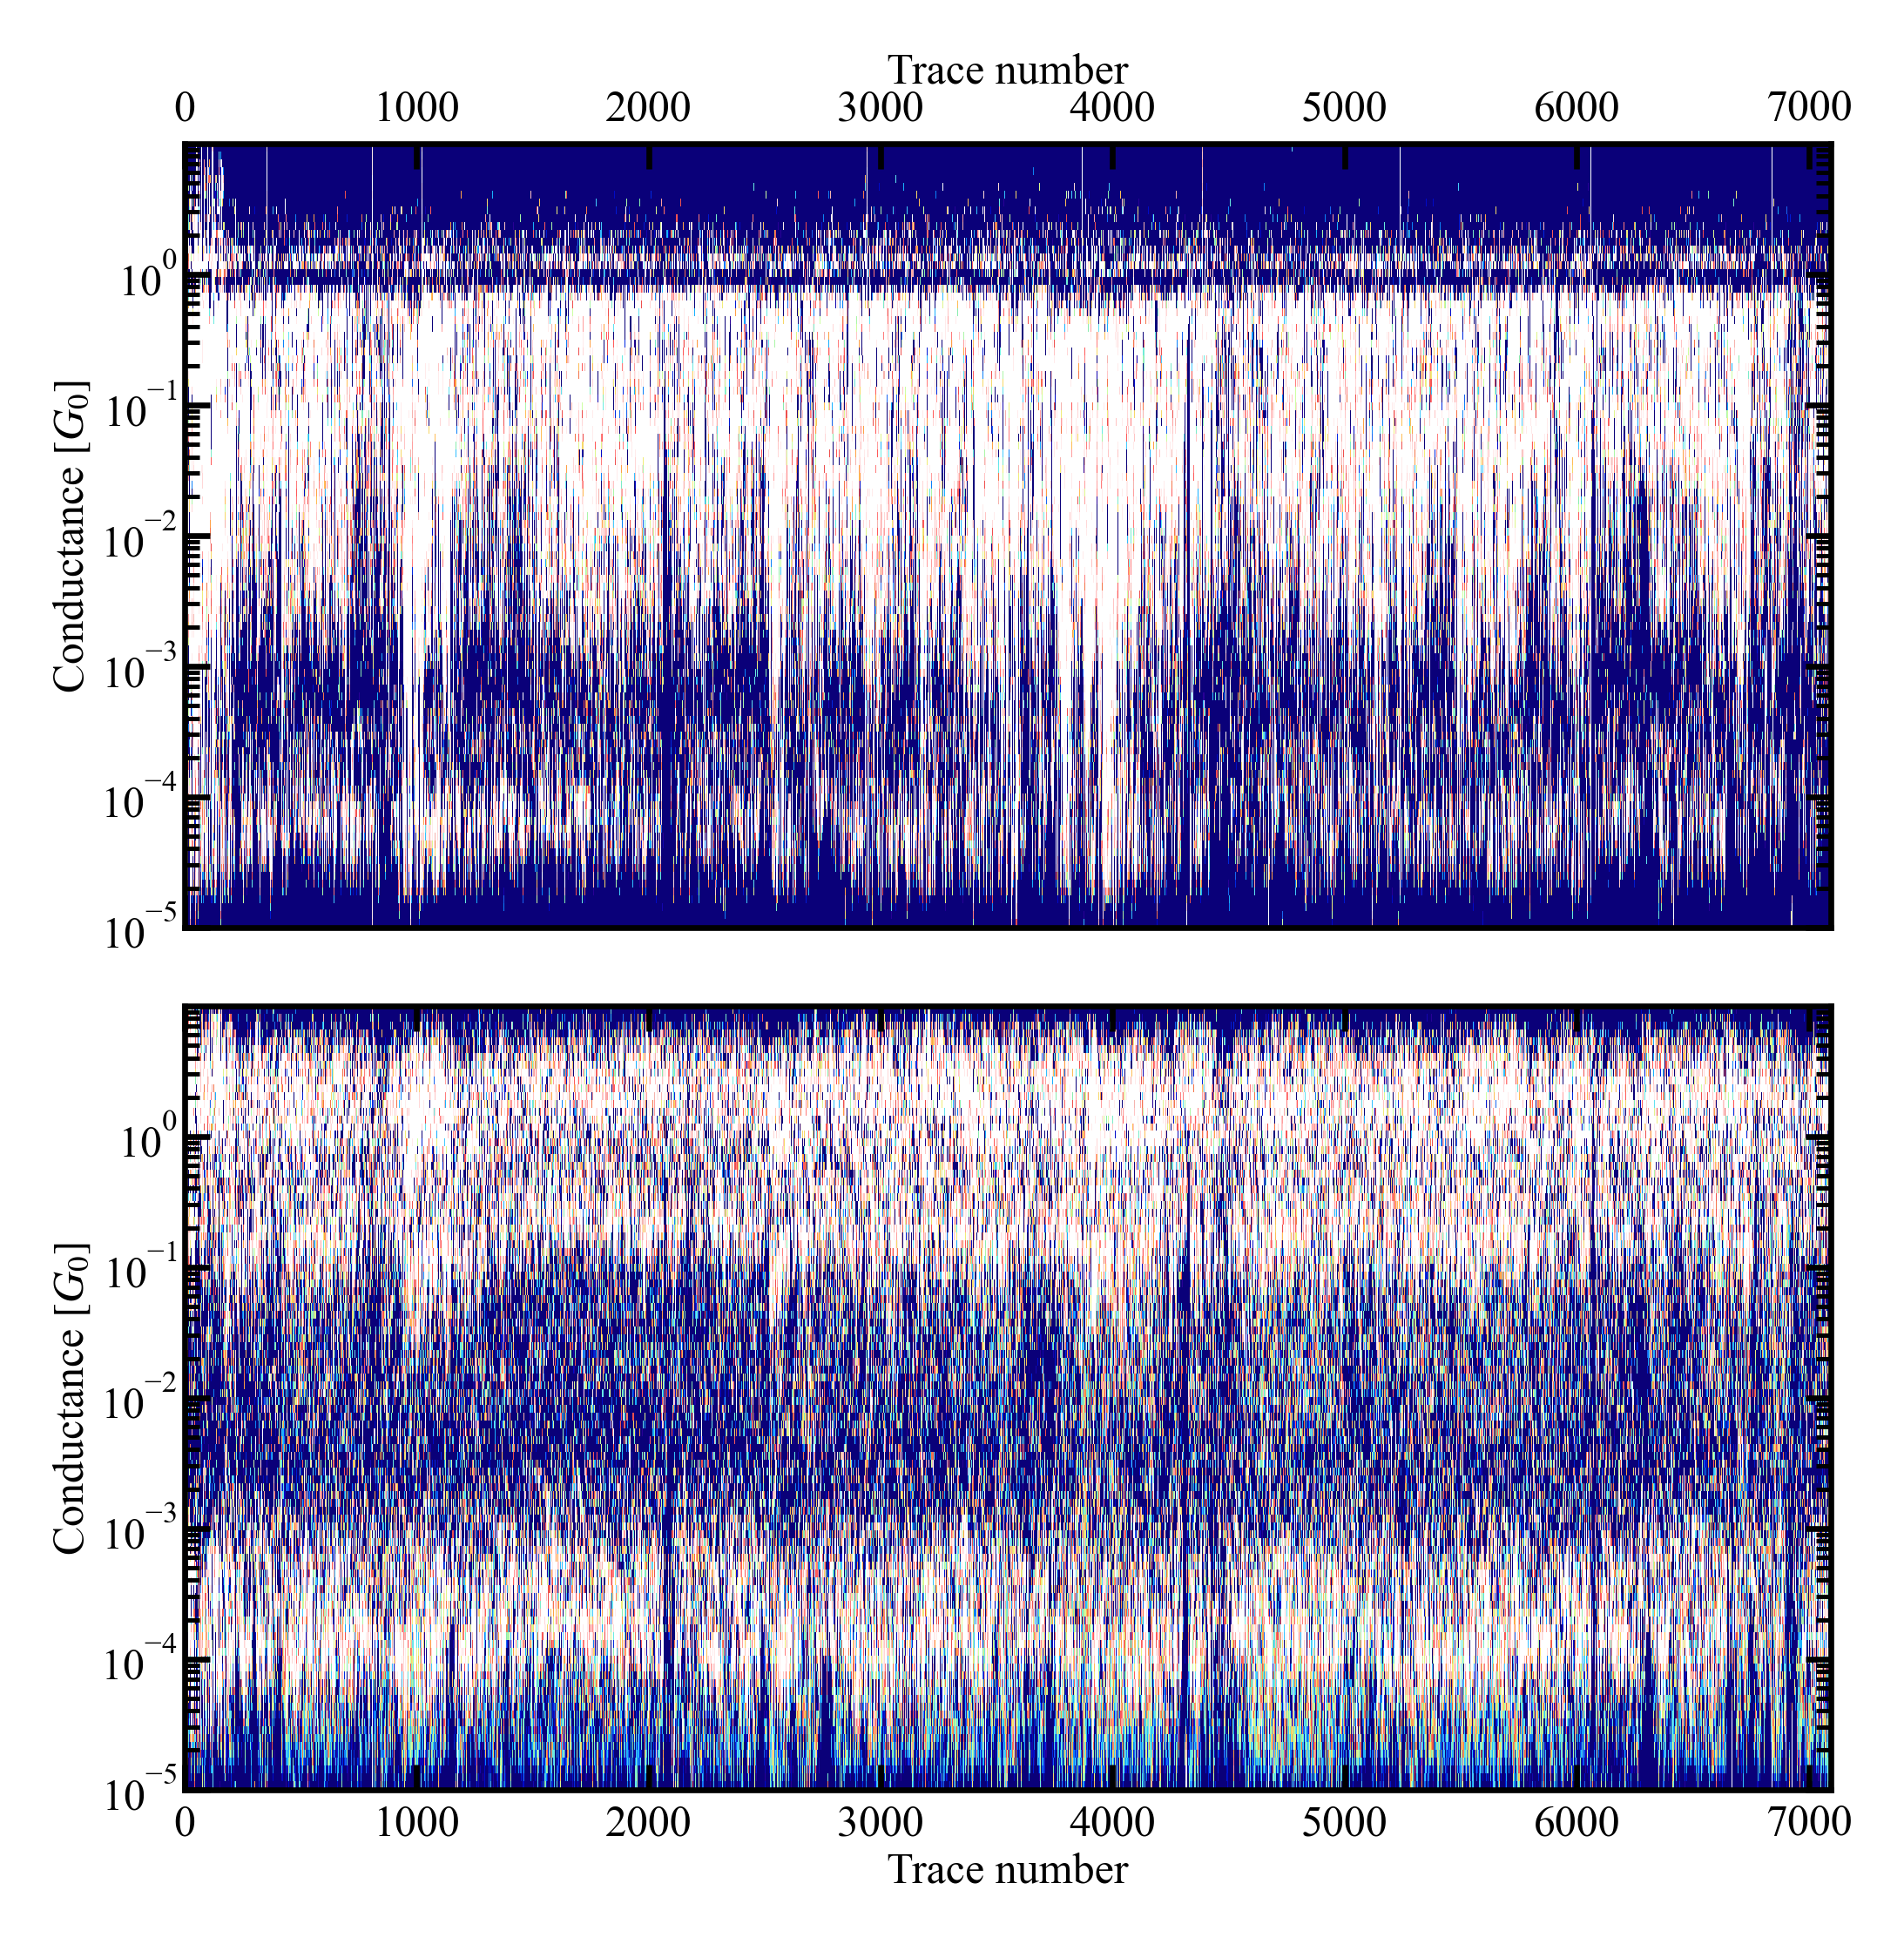

In [36]:
ax_temp_pull, ax_temp_push = hist_parts[0].plot_temporal_hist(vmax_pull=100, vmax_push=1000)
# ax_temp_pull.set_xlim(750, 800)

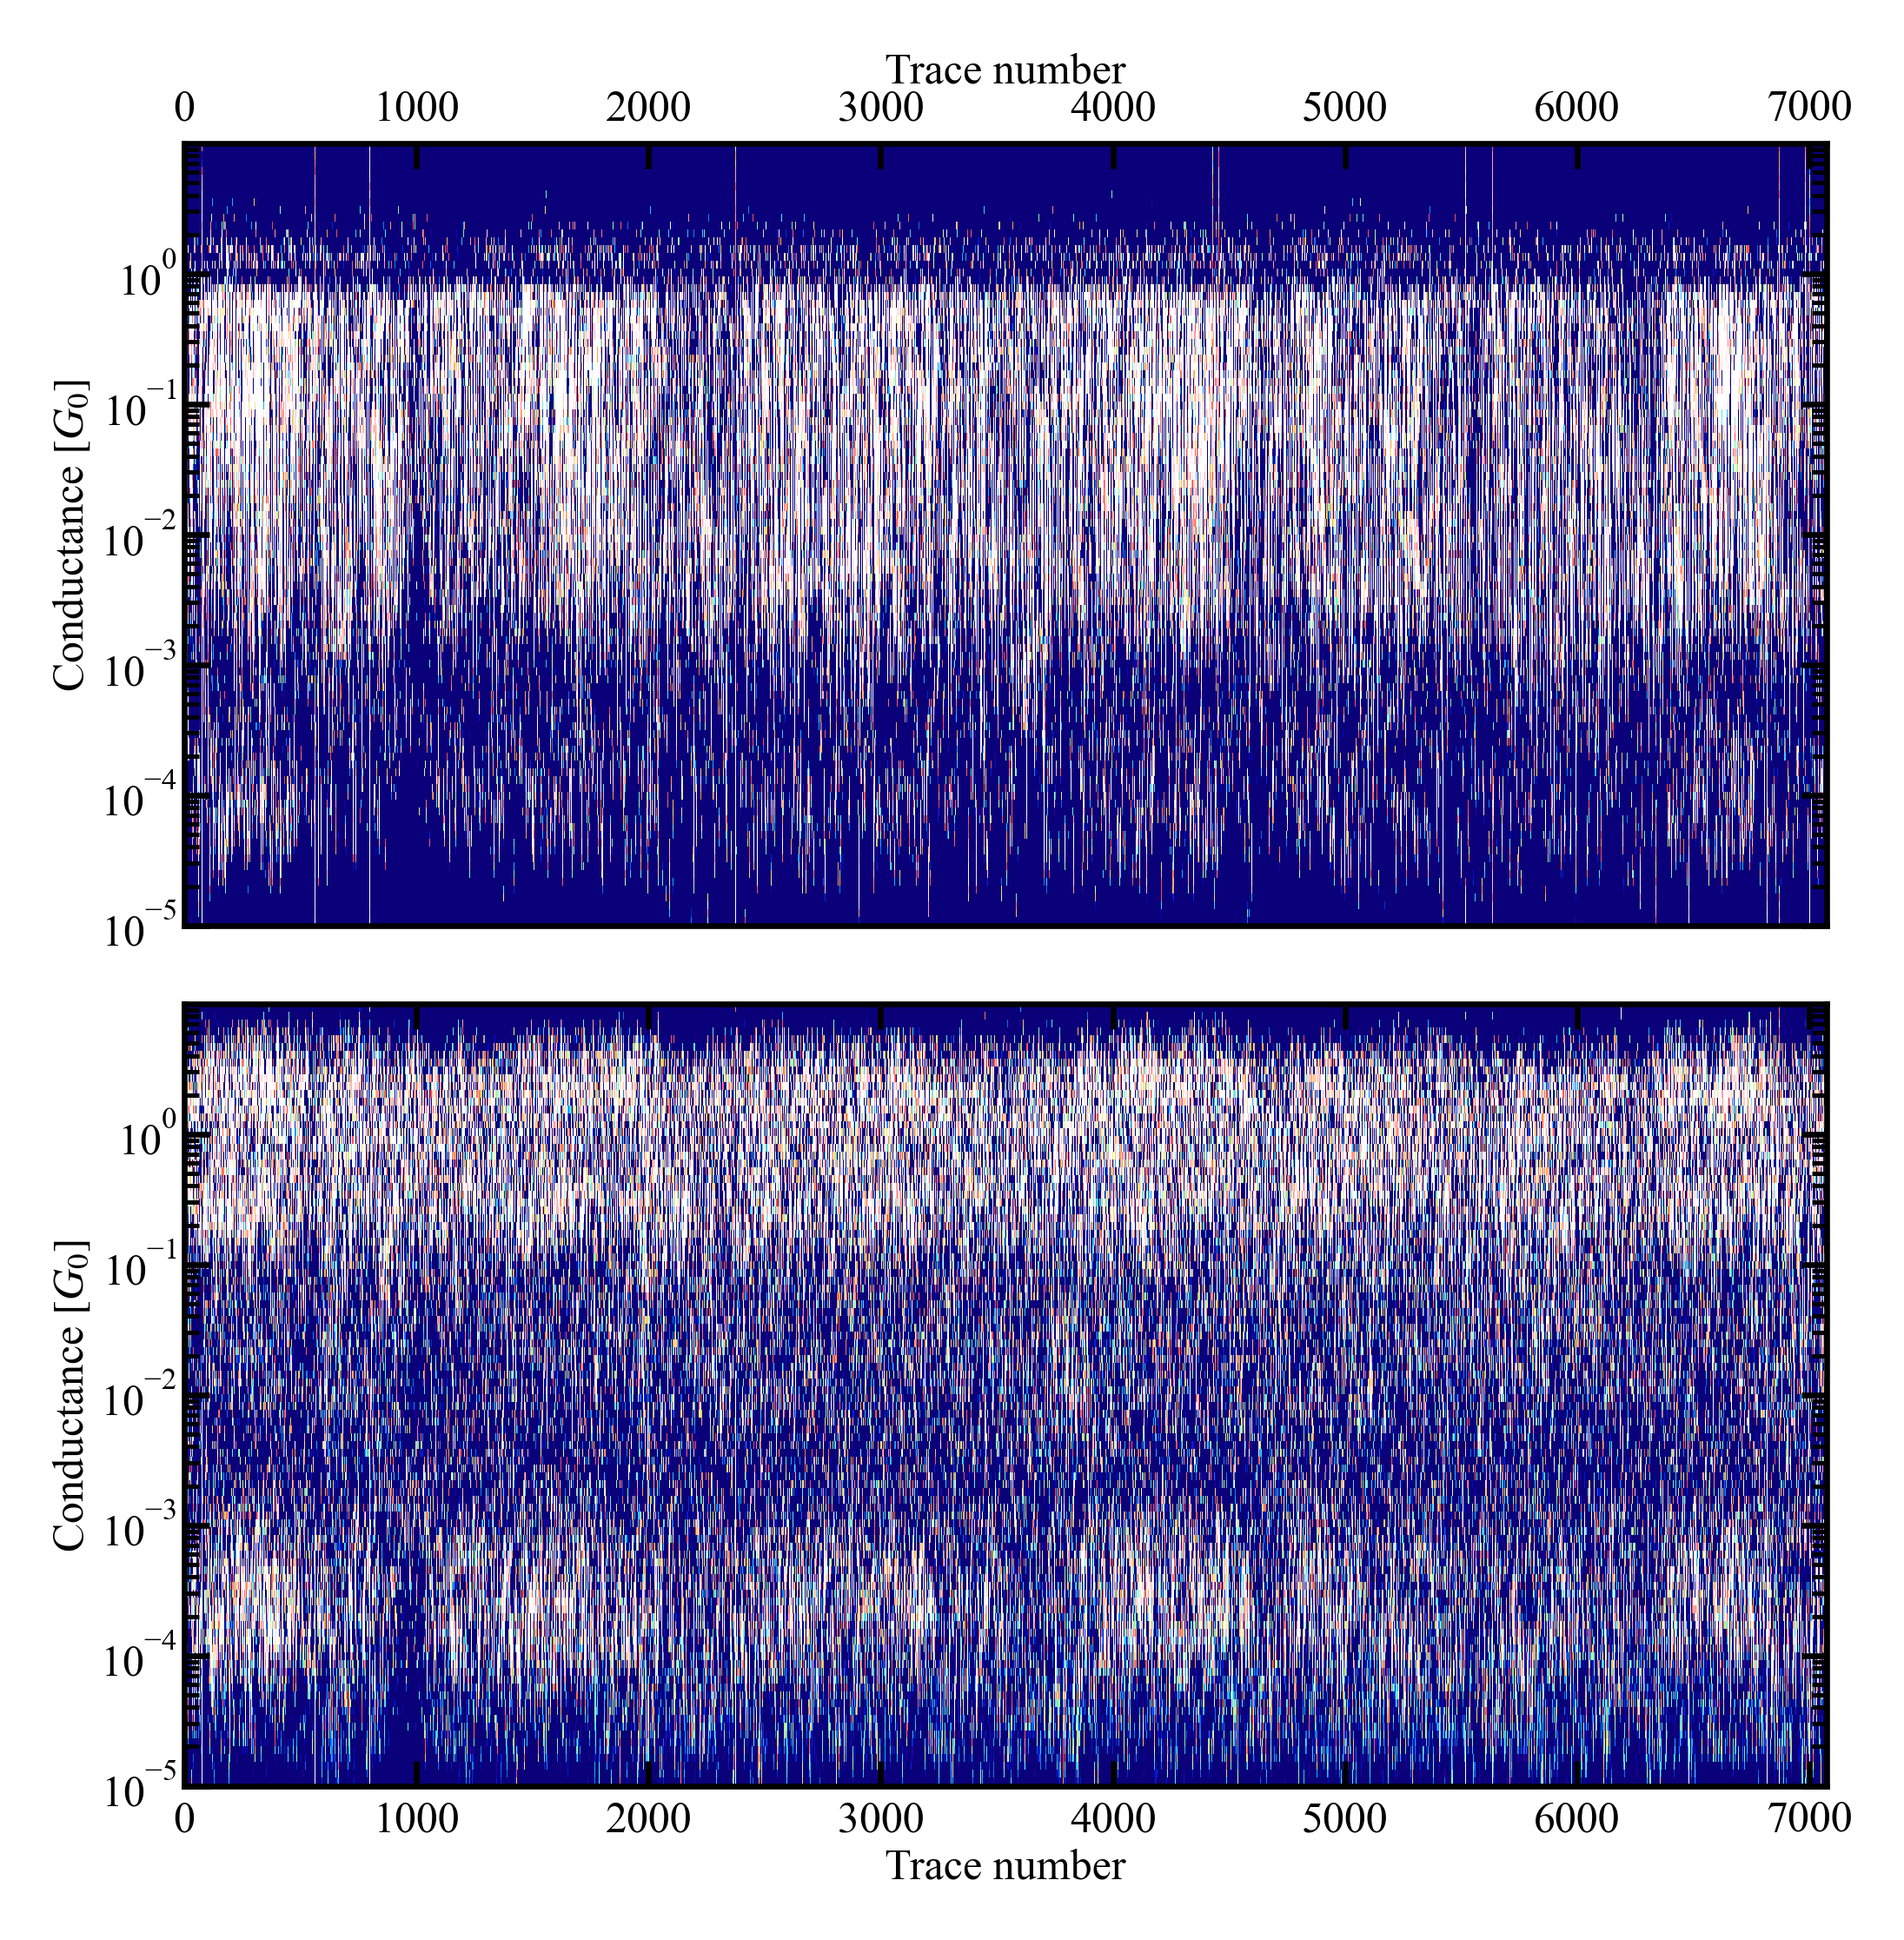

In [26]:
ax_temp_pull, ax_temp_push = hist_parts[1].plot_temporal_hist(vmax_pull=50, vmax_push=500)

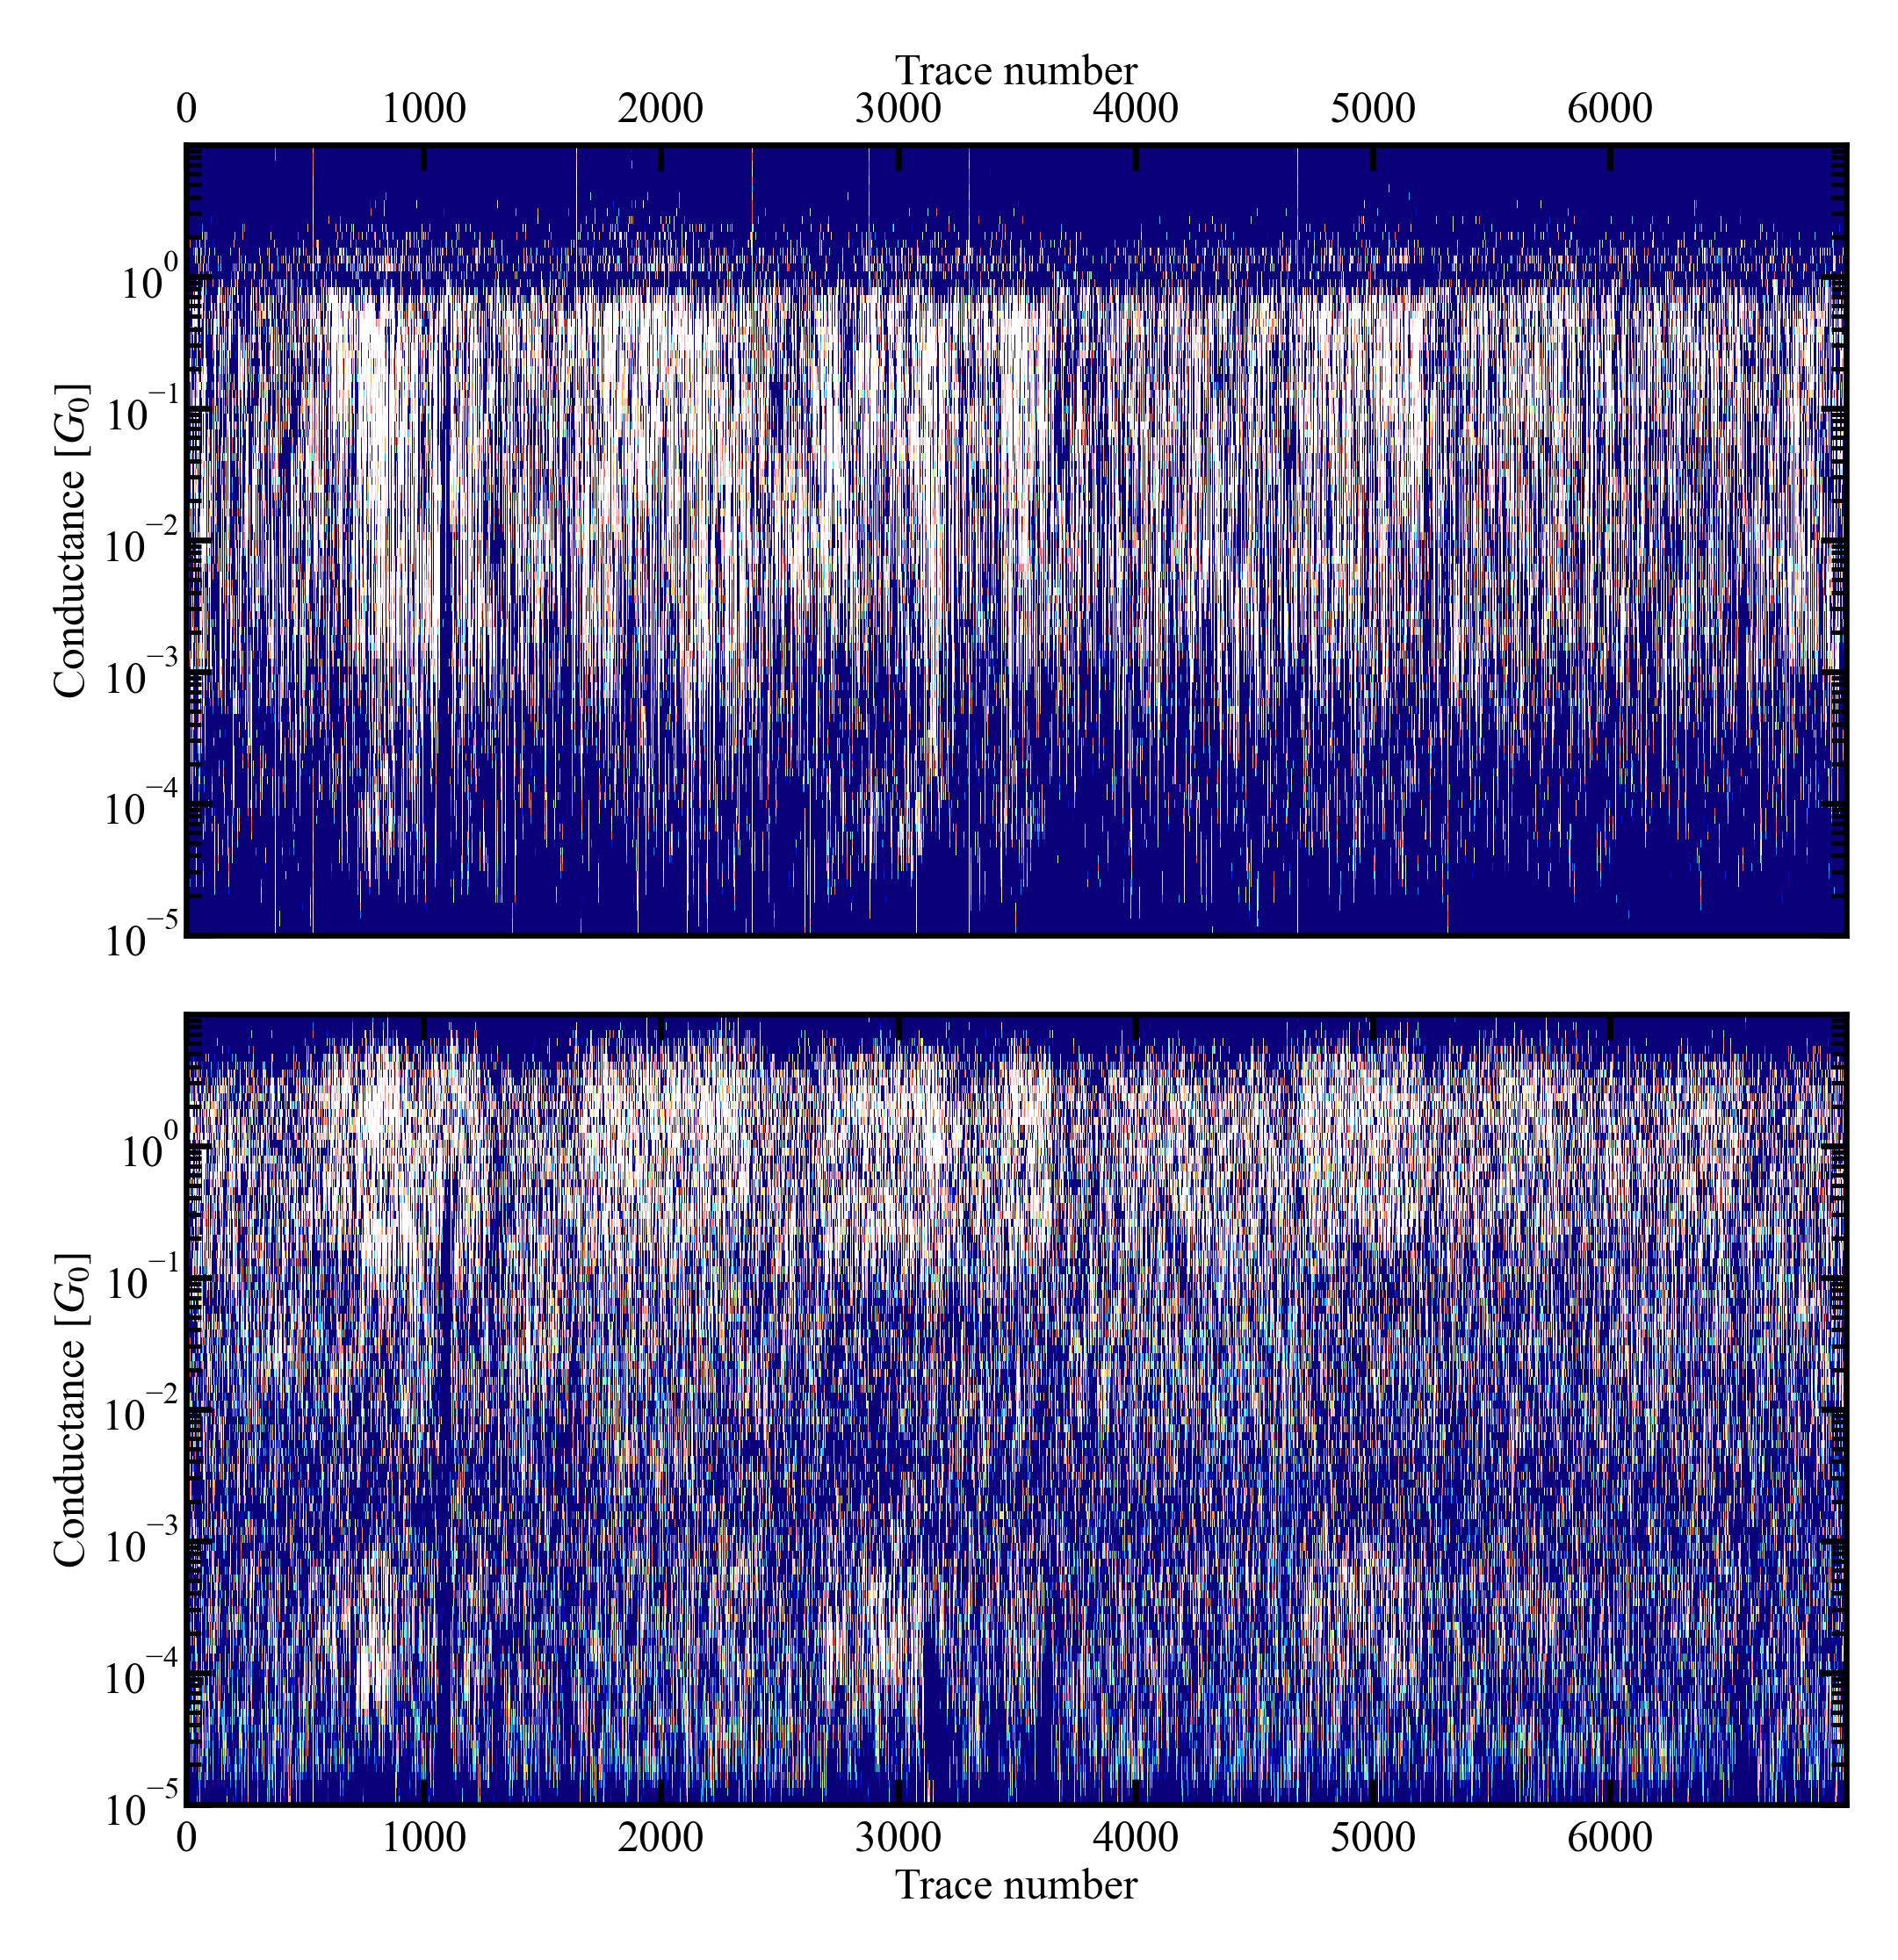

In [27]:
ax_temp_pull, ax_temp_push = hist_parts[2].plot_temporal_hist(vmax_pull=50, vmax_push=500)

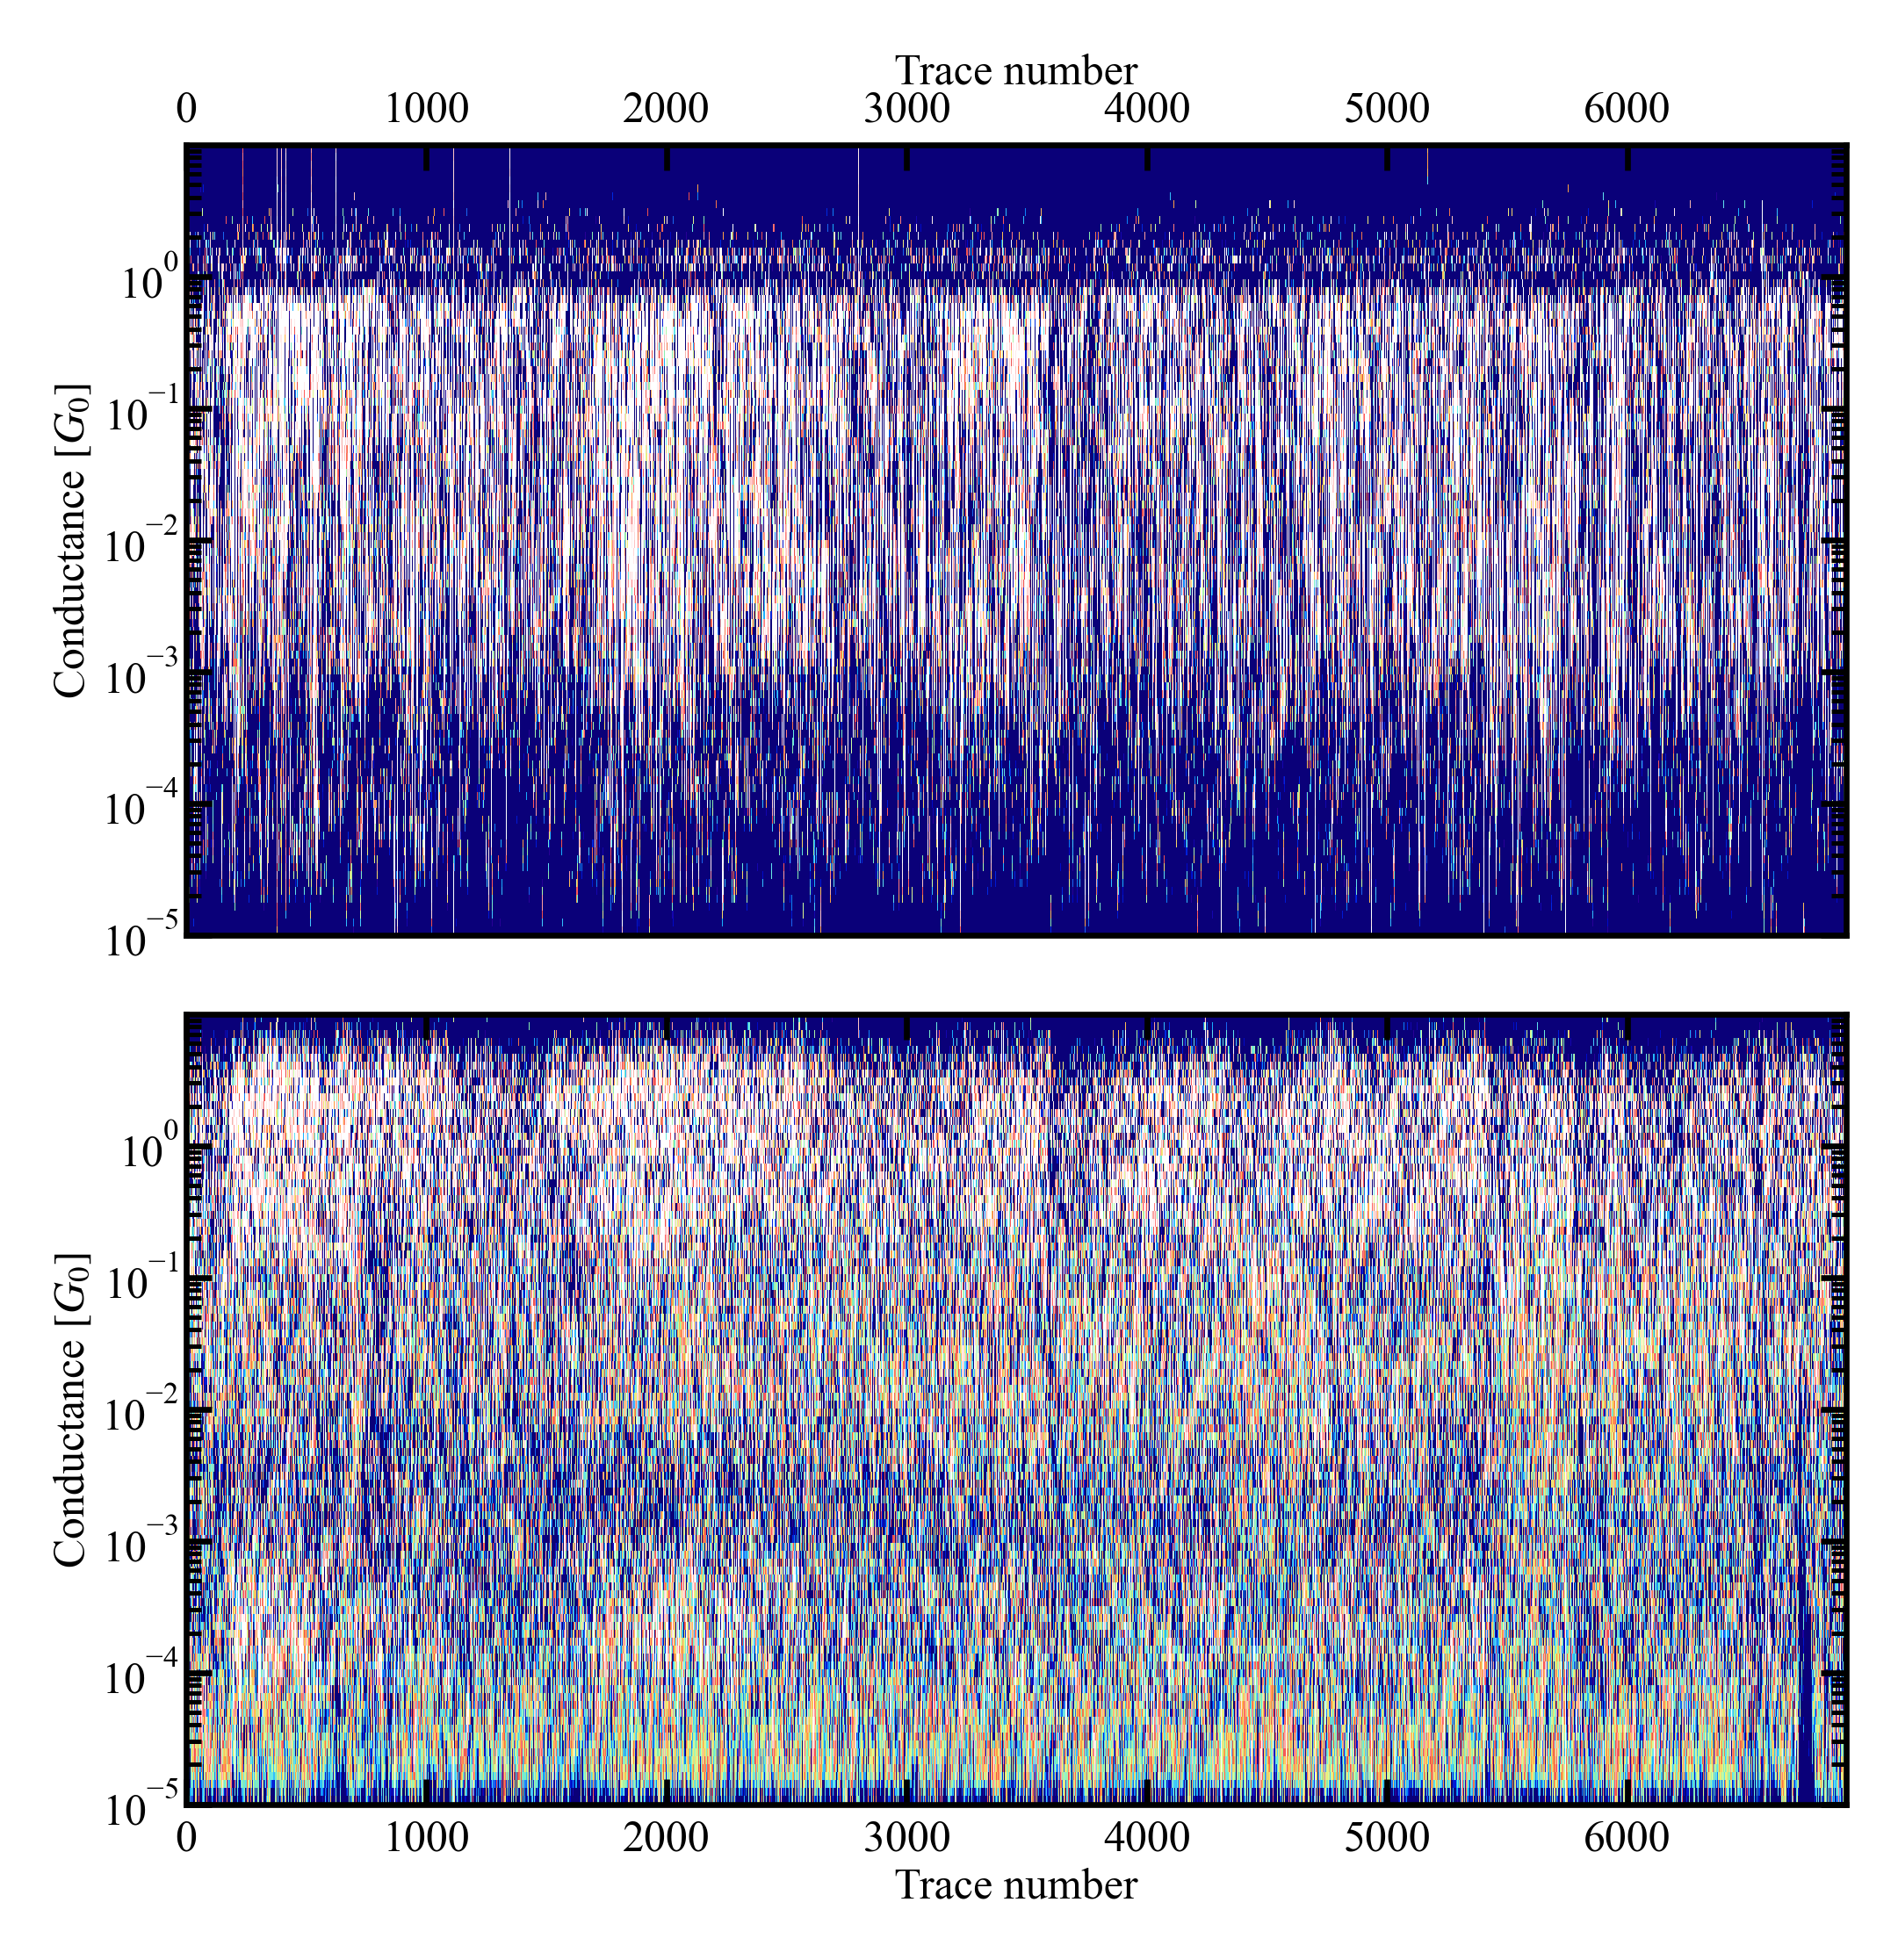

In [30]:
ax_temp_pull, ax_temp_push = hist_parts[3].plot_temporal_hist(vmax_pull=100, vmax_push=1000)

(<AxesSubplot:xlabel='Piezo $[V]$', ylabel='Conductance $[G_{0}]$'>,
 <AxesSubplot:xlabel='Piezo $[V]$', ylabel='Conductance $[G_{0}]$'>)

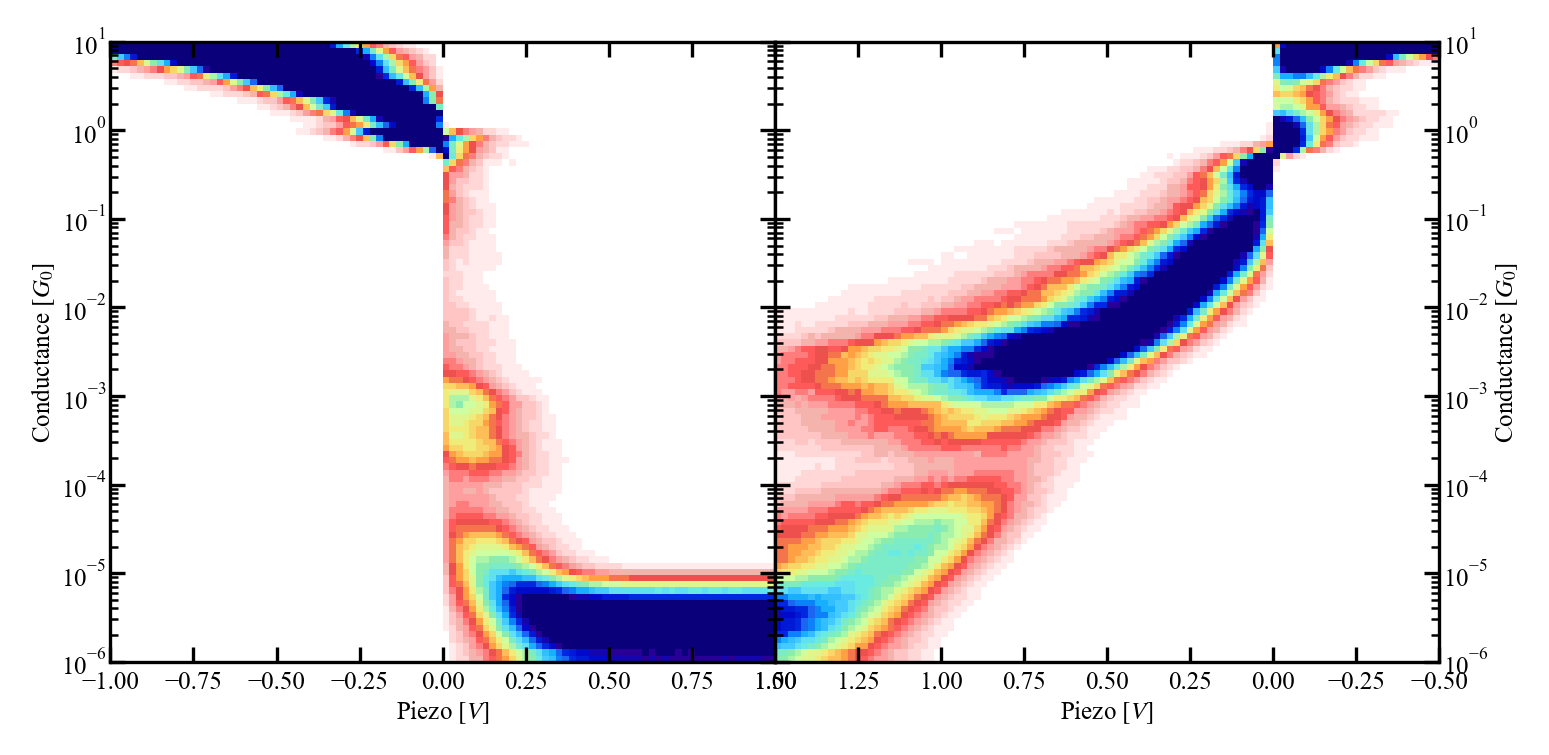

In [9]:
hist.plot_hist_2d_both(dpi=300, vmax=50000)

In [10]:
hist.calc_corr_hist_2d()

  0%|          | 0/8000 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='Conductance $[G_{0}]$', ylabel='Conductance $[G_{0}]$'>,
 <AxesSubplot:>)

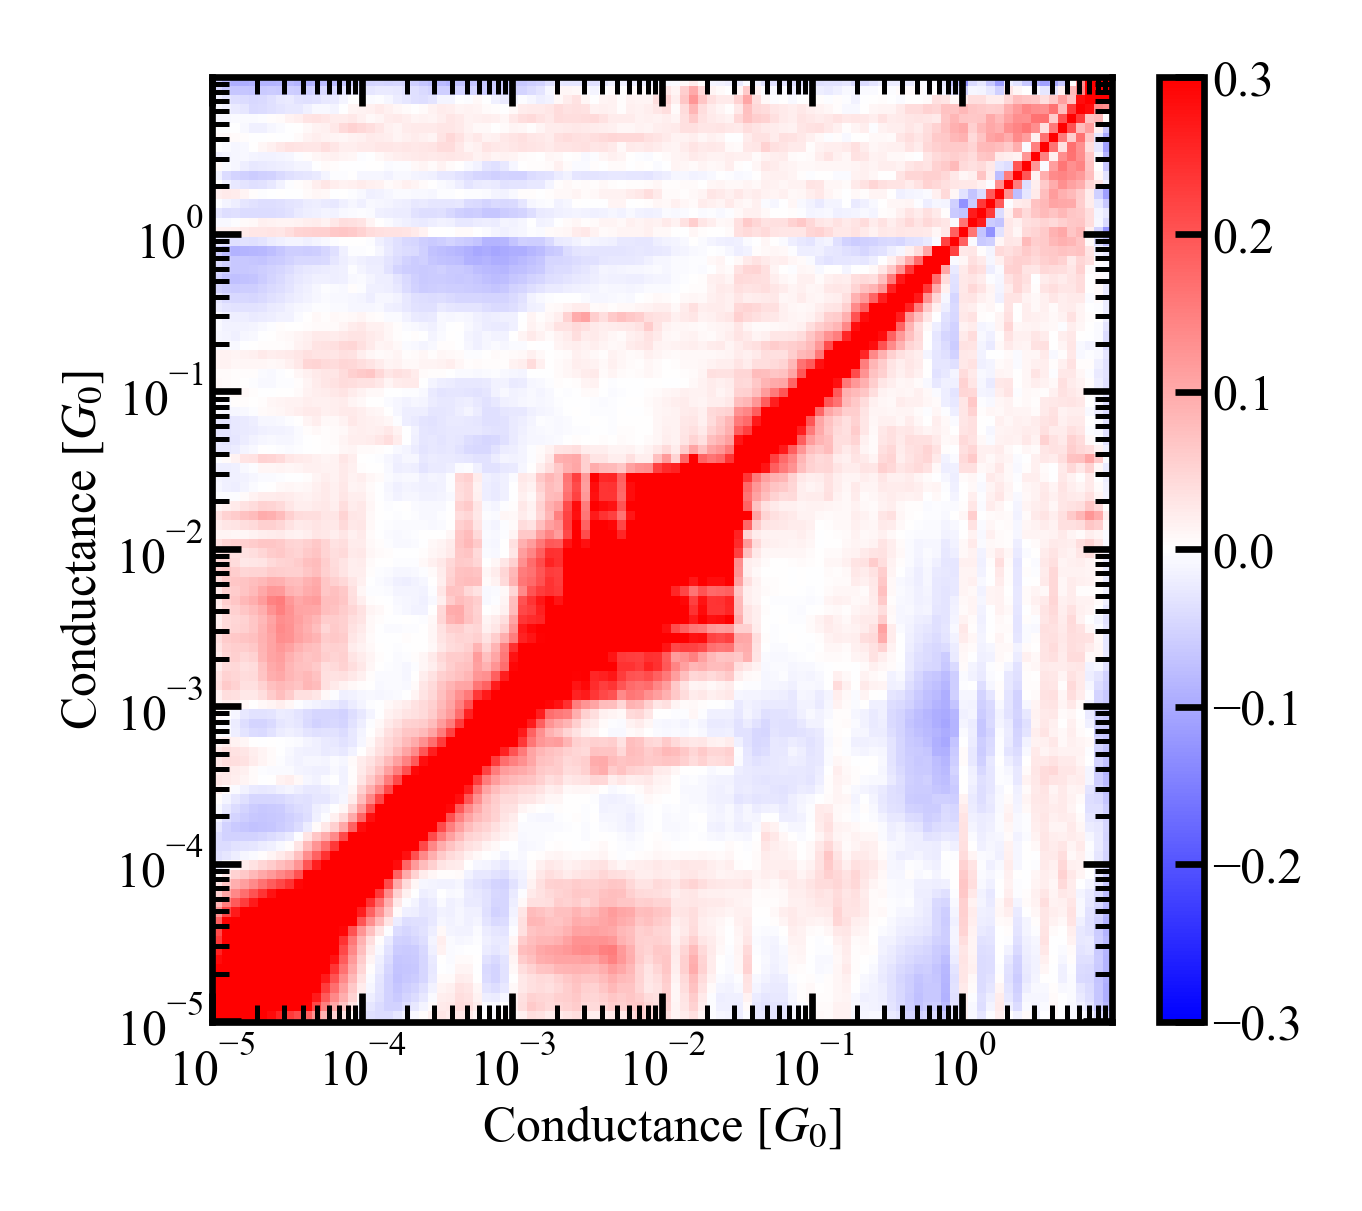

In [11]:
hist.plot_corr(mode='pull', dpi=600, vmin=-0.3, vmax=0.3)

In [12]:
nori_hist_1d = np.loadtxt('D:/Greta/POConductanceHist1D_all_long.txt', skiprows=1)
nori_hist_bins = 10**np.arange(start=-5.82391, step=0.0689284, stop=-5.82391+100*0.0689284)

(1e-05, 10)

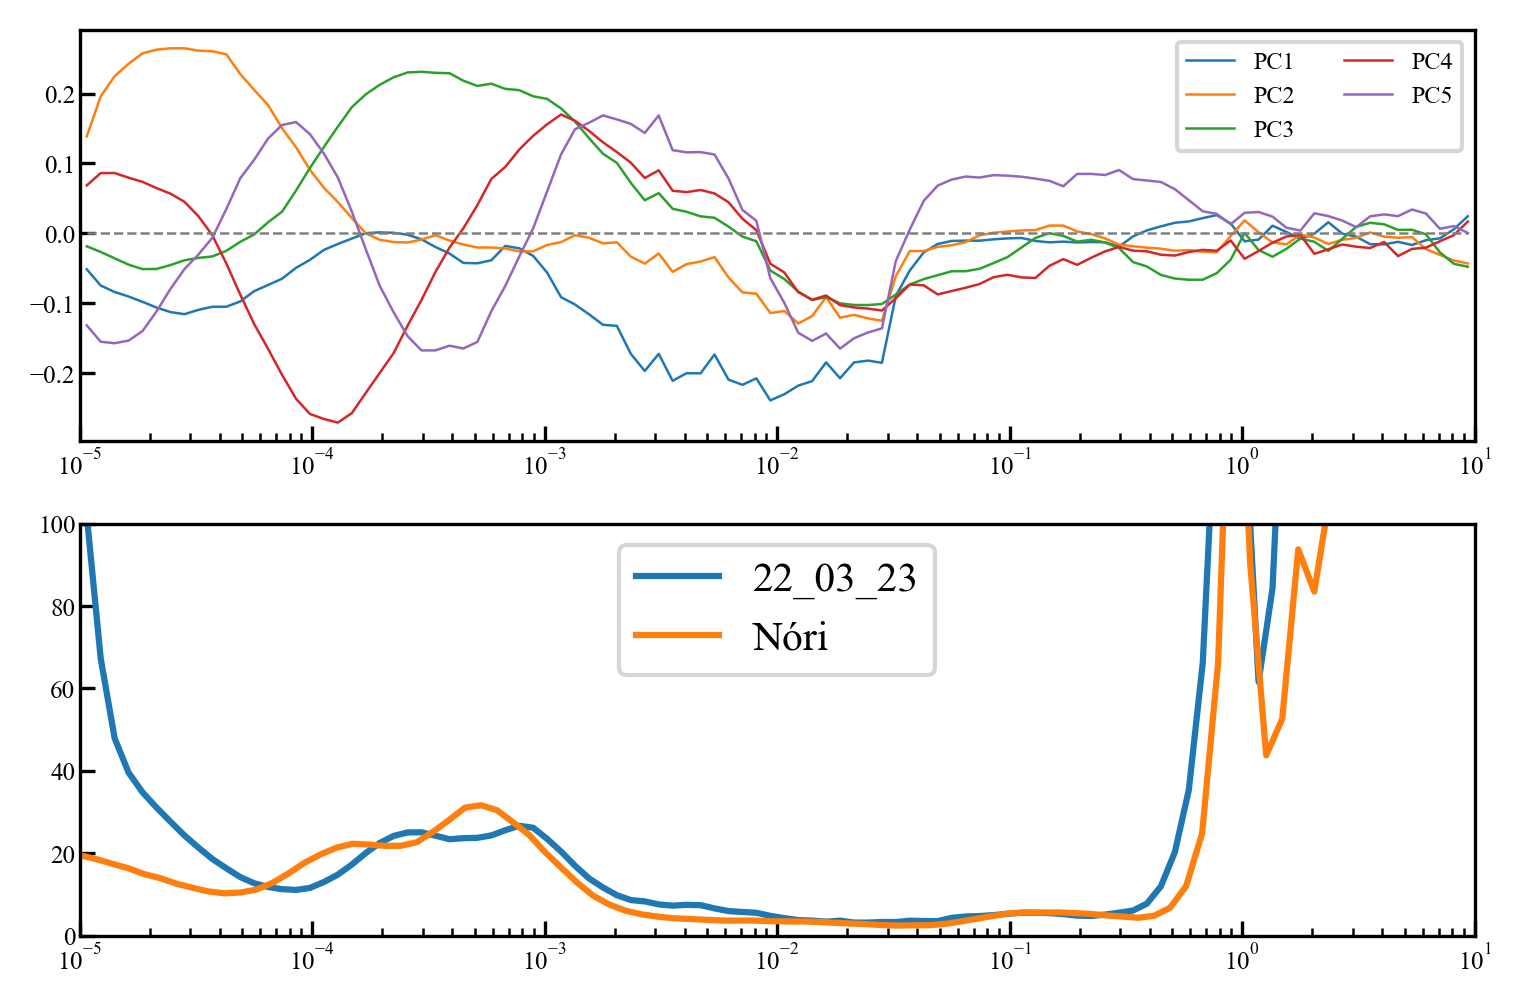

In [13]:
fig, (ax, par) = plt.subplots(nrows=2, dpi=300)

pc = PCA(hist=hist, num_of_pcs=5)
pc.calc_principal_components(direction='pull')
ax = pc.plot_pcs(ax=ax)
# par = ax.twinx()
par.plot(hist.hist_1d_bins, hist.hist_1d_pull, label='22_03_23')
par.set_ylim(0, 100)

par.plot(nori_hist_bins, nori_hist_1d*3, label='Nóri')
par.legend()
par.set_xscale('log')
ax.set_xlim(1e-5, 10)
par.set_xlim(1e-5, 10)

In [14]:
pc.project_to_pcs()

Calculating the projections to PCs.:   0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
pc.calc_pc_hist_all(num_of_bins=100, hist_min=None, hist_max = None)

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
pc.select_percentage(percentage=20, calc_histograms=True)

In [17]:
hist1_1 = Histogram(folder=home_folder,
                    traces=pc.traces_group1['PC1'],
                    conductance_range=(1e-5, 10),  # 4.229e-5
                    conductance_bins_num=100,
                    conductance_bins_mode='total')

hist1_2 = Histogram(folder=home_folder,
                    traces=pc.traces_group2['PC1'],
                    conductance_range=(1e-5, 10),  # 4.229e-5
                    conductance_bins_num=100,
                    conductance_bins_mode='total')

hist2_1 = Histogram(folder=home_folder,
                    traces=pc.traces_group1['PC2'],
                    conductance_range=(1e-5, 10),  # 4.229e-5
                    conductance_bins_num=100,
                    conductance_bins_mode='total')

hist2_2 = Histogram(folder=home_folder,
                    traces=pc.traces_group2['PC2'],
                    conductance_range=(1e-5, 10),  # 4.229e-5
                    conductance_bins_num=100,
                    conductance_bins_mode='total')

hist3_1 = Histogram(folder=home_folder,
                    traces=pc.traces_group1['PC3'],
                    conductance_range=(1e-5, 10),  # 4.229e-5
                    conductance_bins_num=100,
                    conductance_bins_mode='total')

hist3_2 = Histogram(folder=home_folder,
                    traces=pc.traces_group2['PC3'],
                    conductance_range=(1e-5, 10),  # 4.229e-5
                    conductance_bins_num=100,
                    conductance_bins_mode='total')

hist4_1 = Histogram(folder=home_folder,
                    traces=pc.traces_group1['PC4'],
                    conductance_range=(1e-5, 10),  # 4.229e-5
                    conductance_bins_num=100,
                    conductance_bins_mode='total')

hist4_2 = Histogram(folder=home_folder,
                    traces=pc.traces_group2['PC4'],
                    conductance_range=(1e-5, 10),  # 4.229e-5
                    conductance_bins_num=100,
                    conductance_bins_mode='total')

hist5_1 = Histogram(folder=home_folder,
                    traces=pc.traces_group1['PC5'],
                    conductance_range=(1e-5, 10),  # 4.229e-5
                    conductance_bins_num=100,
                    conductance_bins_mode='total')

hist5_2 = Histogram(folder=home_folder,
                    traces=pc.traces_group2['PC5'],
                    conductance_range=(1e-5, 10),  # 4.229e-5
                    conductance_bins_num=100,
                    conductance_bins_mode='total')

In [18]:
hist1_1.calc_stats(align_at=0.5,
                range_pull=(-1, 1),
                range_push=(-0.5, 1.5))

hist1_2.calc_stats(align_at=0.5,
                range_pull=(-1, 1),
                range_push=(-0.5, 1.5))

hist2_1.calc_stats(align_at=0.5,
                range_pull=(-1, 1),
                range_push=(-0.5, 1.5))

hist2_2.calc_stats(align_at=0.5,
                range_pull=(-1, 1),
                range_push=(-0.5, 1.5))
hist3_1.calc_stats(align_at=0.5,
                range_pull=(-1, 1),
                range_push=(-0.5, 1.5))

hist3_2.calc_stats(align_at=0.5,
                range_pull=(-1, 1),
                range_push=(-0.5, 1.5))

hist4_1.calc_stats(align_at=0.5,
                range_pull=(-1, 1),
                range_push=(-0.5, 1.5))

hist4_2.calc_stats(align_at=0.5,
                range_pull=(-1, 1),
                range_push=(-0.5, 1.5))

hist5_1.calc_stats(align_at=0.5,
                range_pull=(-1, 1),
                range_push=(-0.5, 1.5))

hist5_2.calc_stats(align_at=0.5,
                range_pull=(-1, 1),
                range_push=(-0.5, 1.5))

  0%|          | 0/1600 [00:00<?, ?it/s]

Pull 2D histogram created from 1600 traces
Push 2D histogram created from 1600 traces


  0%|          | 0/1600 [00:00<?, ?it/s]

Pull 2D histogram created from 1600 traces
Push 2D histogram created from 1600 traces


  0%|          | 0/1600 [00:00<?, ?it/s]

Pull 2D histogram created from 1600 traces
Push 2D histogram created from 1600 traces


  0%|          | 0/1600 [00:00<?, ?it/s]

Pull 2D histogram created from 1600 traces
Push 2D histogram created from 1600 traces


  0%|          | 0/1600 [00:00<?, ?it/s]

Pull 2D histogram created from 1600 traces
Push 2D histogram created from 1600 traces


  0%|          | 0/1600 [00:00<?, ?it/s]

Pull 2D histogram created from 1600 traces
Push 2D histogram created from 1600 traces


  0%|          | 0/1600 [00:00<?, ?it/s]

Pull 2D histogram created from 1600 traces
Push 2D histogram created from 1600 traces


  0%|          | 0/1600 [00:00<?, ?it/s]

Pull 2D histogram created from 1600 traces
Push 2D histogram created from 1600 traces


  0%|          | 0/1600 [00:00<?, ?it/s]

Pull 2D histogram created from 1600 traces
Push 2D histogram created from 1600 traces


  0%|          | 0/1600 [00:00<?, ?it/s]

Pull 2D histogram created from 1600 traces
Push 2D histogram created from 1600 traces


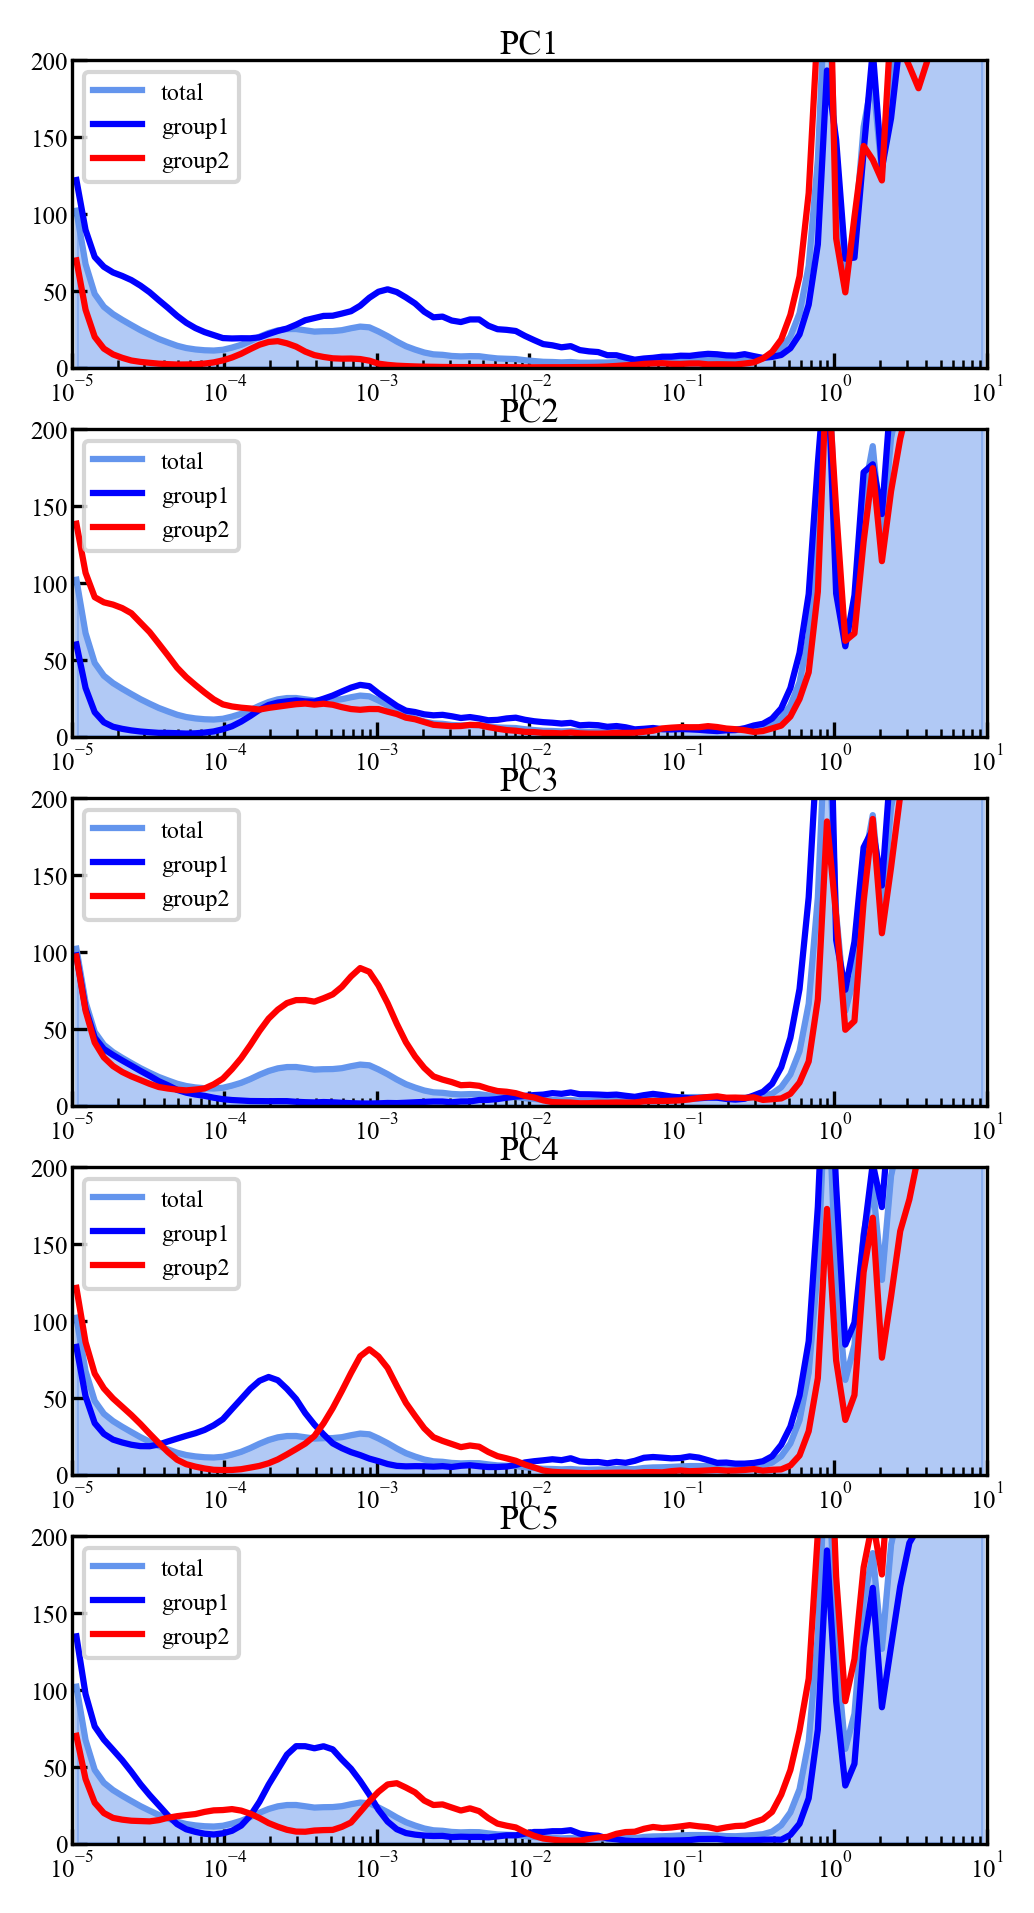

In [23]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, dpi=300, figsize=utils.cm2inch(10, 20))

ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')
ax4.set_xscale('log')
ax5.set_xscale('log')

ax1.set_ylim(0, 200)
ax2.set_ylim(0, 200)
ax3.set_ylim(0, 200)
ax4.set_ylim(0, 200)
ax5.set_ylim(0, 200)

ax1.set_xlim(1e-5, 10)
ax2.set_xlim(1e-5, 10)
ax3.set_xlim(1e-5, 10)
ax4.set_xlim(1e-5, 10)
ax5.set_xlim(1e-5, 10)

ax1.plot(hist.hist_1d_bins, hist.hist_1d_pull, label='total', c='cornflowerblue')
ax1.fill_between(hist.hist_1d_bins, np.zeros_like(hist.hist_1d_pull), hist.hist_1d_pull,
                 alpha=0.5, color='cornflowerblue')
ax2.plot(hist.hist_1d_bins, hist.hist_1d_pull, label='total', c='cornflowerblue')
ax2.fill_between(hist.hist_1d_bins, np.zeros_like(hist.hist_1d_pull), hist.hist_1d_pull,
                 alpha=0.5, color='cornflowerblue')
ax3.plot(hist.hist_1d_bins, hist.hist_1d_pull, label='total', c='cornflowerblue')
ax3.fill_between(hist.hist_1d_bins, np.zeros_like(hist.hist_1d_pull), hist.hist_1d_pull,
                 alpha=0.5, color='cornflowerblue')
ax4.plot(hist.hist_1d_bins, hist.hist_1d_pull, label='total', c='cornflowerblue')
ax4.fill_between(hist.hist_1d_bins, np.zeros_like(hist.hist_1d_pull), hist.hist_1d_pull,
                 alpha=0.5, color='cornflowerblue')
ax5.plot(hist.hist_1d_bins, hist.hist_1d_pull, label='total', c='cornflowerblue')
ax5.fill_between(hist.hist_1d_bins, np.zeros_like(hist.hist_1d_pull), hist.hist_1d_pull,
                 alpha=0.5, color='cornflowerblue')

ax1.plot(hist1_1.hist_1d_bins, hist1_1.hist_1d_pull, label='group1', c='b')
ax1.plot(hist1_2.hist_1d_bins, hist1_2.hist_1d_pull, label='group2', c='r')

ax2.plot(hist2_1.hist_1d_bins, hist2_1.hist_1d_pull, label='group1', c='b')
ax2.plot(hist2_2.hist_1d_bins, hist2_2.hist_1d_pull, label='group2', c='r')

ax3.plot(hist3_1.hist_1d_bins, hist3_1.hist_1d_pull, label='group1', c='b')
ax3.plot(hist3_2.hist_1d_bins, hist3_2.hist_1d_pull, label='group2', c='r')

ax4.plot(hist4_1.hist_1d_bins, hist4_1.hist_1d_pull, label='group1', c='b')
ax4.plot(hist4_2.hist_1d_bins, hist4_2.hist_1d_pull, label='group2', c='r')

ax5.plot(hist5_1.hist_1d_bins, hist5_1.hist_1d_pull, label='group1', c='b')
ax5.plot(hist5_2.hist_1d_bins, hist5_2.hist_1d_pull, label='group2', c='r')

ax1.set_title('PC1', fontsize='small', pad=0)
ax2.set_title('PC2', fontsize='small', pad=0)
ax3.set_title('PC3', fontsize='small', pad=0)
ax4.set_title('PC4', fontsize='small', pad=0)
ax5.set_title('PC5', fontsize='small', pad=0)

ax1.legend(fontsize='xx-small')
ax2.legend(fontsize='xx-small')
ax3.legend(fontsize='xx-small')
ax4.legend(fontsize='xx-small')
ax5.legend(fontsize='xx-small')

<AxesSubplot:>

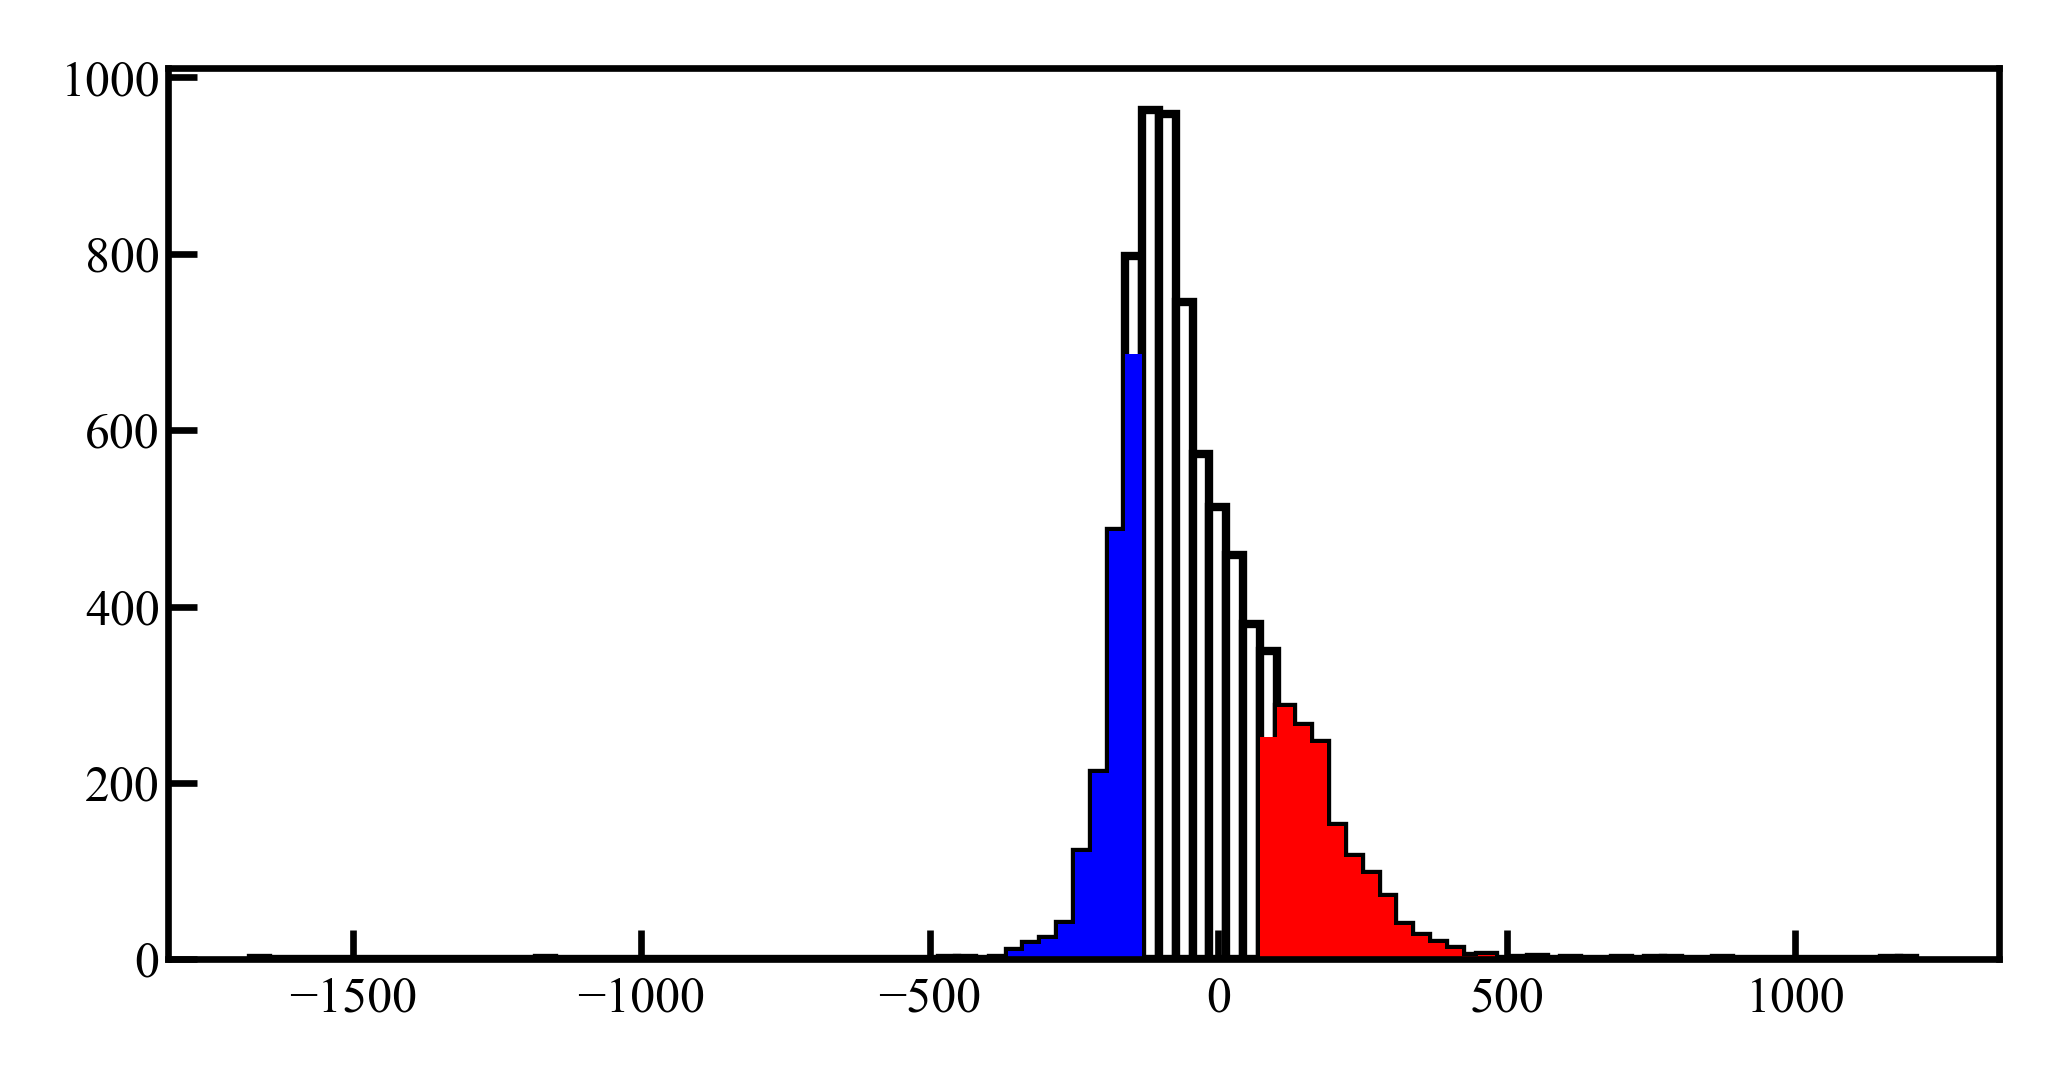

In [20]:
pc.plot_pc_hist(pc_key='PC3', plot_groups=True)